# Weed Detection and Classification with Instance Segmentation
**Date:** 2025-04-05  
**Author:** arfaouiahmed1  
**Framework:** YOLOv8 (Ultralytics)  
**Environment:** Windows 11 (System CUDA 12.8), PyTorch with CUDA 12.1  
**Note:** PyTorch was installed using the official command for CUDA 12.1, which determines the CUDA toolkit version PyTorch interacts with.

This notebook implements an instance segmentation model to detect, outline, and classify different types of weeds using the Roboflow dataset: https://universe.roboflow.com/weeddetection-9usvj/weed_detection-rrlf8/dataset/6

## 1. Business Understanding

### Project Objective
Develop a computer vision model that can:
1. Detect individual weed instances in images
2. Create precise outlines (masks) around each weed
3. Classify each instance by weed type

### Success Criteria
- Instance segmentation with mean average precision (mAP) of at least 0.7
- Classification accuracy of at least 80% for each weed type
- Real-time or near real-time inference (to be deployed on suitable hardware later)

### Use Cases
- Precision agriculture for targeted weed removal
- Agricultural research and weed population monitoring
- Automated farm management systems

## 2. Environment Setup and Data Acquisition

In [1]:
!nvidia-smi

Wed Apr 16 19:39:02 2025       
+-----------------------------------------------------------------------------------------+
| NVIDIA-SMI 560.35.03              Driver Version: 560.35.03      CUDA Version: 12.6     |
|-----------------------------------------+------------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id          Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |           Memory-Usage | GPU-Util  Compute M. |
|                                         |                        |               MIG M. |
|=========================================+========================+======================|
|   0  Tesla P100-PCIE-16GB           Off |   00000000:00:04.0 Off |                    0 |
| N/A   37C    P0             27W /  250W |       0MiB /  16384MiB |      0%      Default |
|                                         |                        |                  N/A |
+-----------------------------------------+-----

In [2]:
!pip install -q accelerate

### 2.1 Setup for Windows 11 with CUDA 12.8

In [3]:
import os


# Create a base directory for the project on Google Drive (if it doesn't exist)
# Adjust the path '/content/drive/MyDrive/Colab Notebooks/YOLOv8_Weed_Detection' as desired
DRIVE_PROJECT_BASE = '/content/drive/MyDrive/Colab_Notebooks/YOLOv8_Weed_Detection' # <--- CHANGE THIS PATH IF NEEDED
os.makedirs(DRIVE_PROJECT_BASE, exist_ok=True)
print(f"Project base directory on Drive: {DRIVE_PROJECT_BASE}")

print("\nInstalling required libraries...")
# Install YOLOv8, Roboflow, and other common dependencies quietly
!pip install ultralytics roboflow opencv-python matplotlib seaborn scikit-learn pandas pyyaml tqdm -q
# Install albumentations for visualization if needed
!pip install -q albumentations

print("\nDependency installation complete.")

Project base directory on Drive: /content/drive/MyDrive/Colab_Notebooks/YOLOv8_Weed_Detection

Installing required libraries...
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 974.8/974.8 kB 24.4 MB/s eta 0:00:0000:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 85.2/85.2 kB 3.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 66.8/66.8 kB 3.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.8/7.8 MB 91.5 MB/s eta 0:00:00:00:0100:01
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
tensorflow-decision-forests 1.10.0 requires tensorflow==2.17.0, but you have tensorflow 2.17.1 which is incompatible.

Dependency installation complete.


In [4]:
# Verify CUDA is available and which version is being used
import torch
print(f"CUDA available: {torch.cuda.is_available()}")
if torch.cuda.is_available():
    print(f"CUDA version: {torch.version.cuda}")
    print(f"Number of GPUs: {torch.cuda.device_count()}")
    for i in range(torch.cuda.device_count()):
        print(f"GPU {i}: {torch.cuda.get_device_name(i)}")

CUDA available: True
CUDA version: 12.1
Number of GPUs: 1
GPU 0: Tesla P100-PCIE-16GB


In [5]:
# Import necessary libraries
import os
import sys
import json
import random
import numpy as np
import matplotlib.pyplot as plt
import cv2
import pandas as pd
import seaborn as sns
from pathlib import Path
from datetime import datetime
from tqdm.auto import tqdm

# For YOLOv8
from ultralytics import YOLO

# Set random seed for reproducibility
seed = 42
random.seed(seed)
np.random.seed(seed)
torch.manual_seed(seed)
torch.cuda.manual_seed_all(seed)

# Set environment variables for better performance on Windows with CUDA
os.environ["KMP_DUPLICATE_LIB_OK"] = "TRUE"
torch.backends.cudnn.benchmark = True  # May improve performance

Creating new Ultralytics Settings v0.0.6 file ✅ 
View Ultralytics Settings with 'yolo settings' or at '/root/.config/Ultralytics/settings.json'
Update Settings with 'yolo settings key=value', i.e. 'yolo settings runs_dir=path/to/dir'. For help see https://docs.ultralytics.com/quickstart/#ultralytics-settings.


### 2.2 Download and Explore Dataset

In [6]:
# Download and extract the dataset from Roboflow
from roboflow import Roboflow

# Initialize Roboflow (You'll need to get your API key from Roboflow)
rf = Roboflow(api_key="HE9CEH5JxJ3U0vXrQTOy")

# Access the project and version
project = rf.workspace("weeddetection-9usvj").project("weed_detection-rrlf8")

# For YOLOv8 segmentation, we need YOLO format
dataset = project.version(6).download("yolov8")

# Get the dataset path
dataset_path = Path(dataset.location)

loading Roboflow workspace...
loading Roboflow project...


In [7]:
# Explore the dataset structure
print(f"Dataset path: {dataset_path}")

# List directories
print("\nDirectories:")
for item in os.listdir(dataset_path):
    if os.path.isdir(os.path.join(dataset_path, item)):
        print(f"- {item}")

# Check for data.yaml file which contains dataset configuration
data_yaml_path = dataset_path / "data.yaml"
if os.path.exists(data_yaml_path):
    print(f"\nData configuration file found: {data_yaml_path}")

    # Display YAML content
    import yaml
    with open(data_yaml_path, 'r') as f:
        data_yaml = yaml.safe_load(f)
        print("\nDataset configuration:")
        for key, value in data_yaml.items():
            print(f"- {key}: {value}")
else:
    print("Data configuration file (data.yaml) not found!")

Dataset path: /kaggle/working/weed_detection-6

Directories:
- train
- valid
- test

Data configuration file found: /kaggle/working/weed_detection-6/data.yaml

Dataset configuration:
- names: ['carpetweeds', 'crabgrass', 'eclipta', 'goosegrass', 'morningglory', 'nutsedge', 'palmeramaranth', 'pricklysida', 'purslane', 'ragweed', 'sicklepod', 'spottedspurge', 'spurredanoda', 'swinecress', 'waterhemp']
- nc: 15
- roboflow: {'license': 'CC BY 4.0', 'project': 'weed_detection-rrlf8', 'url': 'https://universe.roboflow.com/weeddetection-9usvj/weed_detection-rrlf8/dataset/6', 'version': 6, 'workspace': 'weeddetection-9usvj'}
- test: ../test/images
- train: ../train/images
- val: ../valid/images


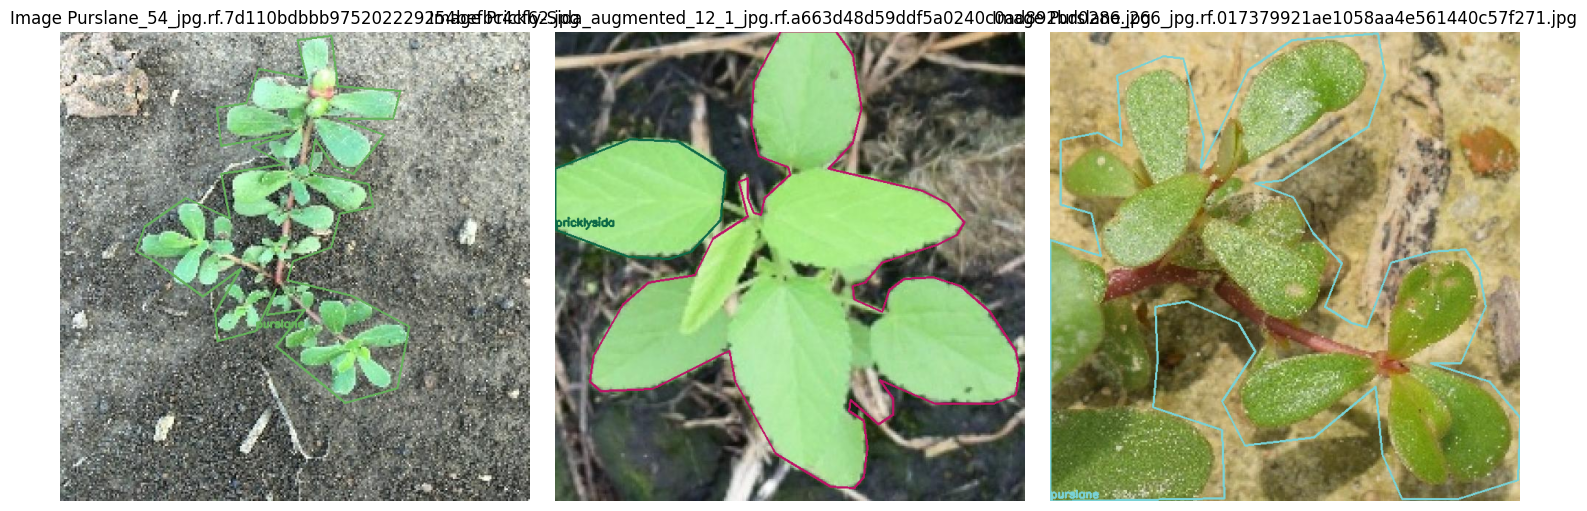

In [8]:
# Visualize some examples from the dataset
def visualize_yolo_annotations(dataset_path, num_samples=3):
    # Directories for images and labels
    train_img_dir = dataset_path / "train" / "images"
    train_label_dir = dataset_path / "train" / "labels"

    # Load class names from data.yaml
    with open(dataset_path / "data.yaml", 'r') as f:
        data_cfg = yaml.safe_load(f)
        class_names = data_cfg['names']

    # Get random sample images
    image_files = [f for f in os.listdir(train_img_dir) if f.endswith(('.jpg', '.jpeg', '.png'))]
    sample_images = random.sample(image_files, min(num_samples, len(image_files)))

    # Create a figure for display
    fig, axes = plt.subplots(1, num_samples, figsize=(15, 5))
    if num_samples == 1:
        axes = [axes]

    # Plot each sample image with annotations
    for i, img_file in enumerate(sample_images):
        # Get corresponding label file
        label_file = os.path.splitext(img_file)[0] + ".txt"
        label_path = train_label_dir / label_file

        # Load image
        img_path = train_img_dir / img_file
        image = cv2.imread(str(img_path))
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        height, width = image.shape[:2]

        # Load and parse annotation if it exists
        if os.path.exists(label_path):
            with open(label_path, 'r') as f:
                lines = f.readlines()

            for line in lines:
                # Parse YOLO format annotation
                parts = line.strip().split(' ')
                class_id = int(parts[0])
                # For segmentation masks, format is: class_id x1 y1 x2 y2 x3 y3 ...
                if len(parts) > 5:  # It's a segmentation mask
                    # Convert normalized polygon coordinates to image coordinates
                    polygon = []
                    for j in range(1, len(parts), 2):
                        if j+1 < len(parts):
                            x = float(parts[j]) * width
                            y = float(parts[j+1]) * height
                            polygon.append([x, y])

                    # Draw the polygon
                    polygon = np.array(polygon, dtype=np.int32)
                    color = np.random.randint(0, 255, 3).tolist()
                    cv2.polylines(image, [polygon], True, color, 2)

                    # Get class name
                    class_name = class_names[class_id] if class_id < len(class_names) else f"Class {class_id}"

                    # Add label at a position near the polygon
                    if len(polygon) > 0:
                        x, y = polygon[0]
                        cv2.putText(image, class_name, (int(x), int(y-5)),
                                   cv2.FONT_HERSHEY_SIMPLEX, 0.5, color, 2)
                else:  # It's a bounding box (should not happen for segmentation, but just in case)
                    center_x, center_y, w, h = map(float, parts[1:5])
                    x1 = int((center_x - w/2) * width)
                    y1 = int((center_y - h/2) * height)
                    x2 = int((center_x + w/2) * width)
                    y2 = int((center_y + h/2) * height)

                    color = np.random.randint(0, 255, 3).tolist()
                    cv2.rectangle(image, (x1, y1), (x2, y2), color, 2)

                    # Get class name
                    class_name = class_names[class_id] if class_id < len(class_names) else f"Class {class_id}"
                    cv2.putText(image, class_name, (x1, y1-5), cv2.FONT_HERSHEY_SIMPLEX, 0.5, color, 2)

        # Display the annotated image
        axes[i].imshow(image)
        axes[i].set_title(f"Image {img_file}")
        axes[i].axis('off')

    plt.tight_layout()
    plt.show()

# Visualize sample images
visualize_yolo_annotations(dataset_path, 3)

In [9]:
import os
from pathlib import Path
import yaml

print(f"Starting detailed label check for dataset at: {dataset_path}")

# --- Configuration ---
try:
    # Load nc (number of classes) from the augmented yaml
    data_yaml_to_check = dataset_path / "data_augmented.yaml"
    if not data_yaml_to_check.exists():
        data_yaml_to_check = dataset_path / "data.yaml" # Fallback to original
        if not data_yaml_to_check.exists():
             raise FileNotFoundError("Cannot find data.yaml or data_augmented.yaml")

    with open(data_yaml_to_check, 'r') as f:
        data_cfg = yaml.safe_load(f)
        if 'nc' not in data_cfg:
             raise ValueError("'nc' (number of classes) not found in YAML.")
        num_classes = int(data_cfg['nc'])
    print(f"Number of classes defined in {data_yaml_to_check.name}: {num_classes}")
except Exception as e:
    print(f"Error loading configuration from YAML: {e}")
    print("Cannot proceed with class ID checks.")
    num_classes = None # Set to None if loading failed

# --- Check Function ---
def check_segmentation_label_file(filepath, num_classes):
    issues = []
    if not os.path.exists(filepath):
        issues.append("File does not exist (should not happen if iterating correctly)")
        return issues
    if os.path.getsize(filepath) == 0:
        issues.append("File is empty (0 bytes)")
        # Don't return yet, check if it has lines anyway (unlikely)

    try:
        with open(filepath, 'r') as f:
            lines = f.readlines()

        if not lines:
             if "File is empty (0 bytes)" not in issues: # Avoid duplicate message
                 issues.append("File exists but contains no lines")
             return issues # No point checking lines if there are none

        has_valid_line = False
        for i, line in enumerate(lines):
            line_num = i + 1
            parts = line.strip().split()
            if not parts: # Skip empty lines within the file
                continue

            # Check number of parts (class_id + at least 2 pairs of coords)
            if len(parts) < 5 or len(parts) % 2 != 1:
                issues.append(f"Line {line_num}: Incorrect number of values ({len(parts)}). Expected class_id + pairs of coords.")
                continue # Skip further checks for this malformed line

            # Check Class ID
            class_id_str = parts[0]
            try:
                class_id = int(class_id_str)
                if num_classes is not None: # Only check if nc was loaded
                     if not (0 <= class_id < num_classes):
                         issues.append(f"Line {line_num}: Class ID '{class_id}' is outside the valid range [0, {num_classes-1}]")
            except ValueError:
                issues.append(f"Line {line_num}: Class ID '{class_id_str}' is not an integer.")
                continue # Skip coordinate checks if class ID is bad

            # Check Coordinates are numeric and in range [0, 1]
            all_coords_valid = True
            for j, coord_str in enumerate(parts[1:]):
                try:
                    coord = float(coord_str)
                    if not (0.0 <= coord <= 1.0):
                         # Allow slightly outside range due to augmentation/rounding, but flag significant issues
                         if not (-0.1 <= coord <= 1.1):
                             issues.append(f"Line {line_num}: Coordinate {j+1} ('{coord}') is significantly outside the expected range [0, 1]")
                             all_coords_valid = False
                         # else: # Optionally add warning for minor deviations
                         #    issues.append(f"Warning - Line {line_num}: Coordinate {j+1} ('{coord}') is slightly outside [0, 1]")

                except ValueError:
                    issues.append(f"Line {line_num}: Coordinate {j+1} ('{coord_str}') is not a number.")
                    all_coords_valid = False

            if all_coords_valid:
                 has_valid_line = True # Found at least one line that looks okay

        # After checking all lines
        if not has_valid_line and lines and not any("Incorrect number of values" in iss or "Class ID" in iss for iss in issues):
             # File had lines, but none were considered valid segmentation lines after checks
             issues.append("File contains lines, but none seem to be valid segmentation annotations.")
        elif not has_valid_line and not lines:
             if "File exists but contains no lines" not in issues and "File is empty (0 bytes)" not in issues:
                  issues.append("File appears empty or contains only invalid lines.")


    except Exception as e:
        issues.append(f"Failed to read or process file: {str(e)}")

    return issues

# --- Iterate and Check ---
total_issues = 0
max_files_to_print = 20 # Limit printing excessively long lists
problem_files = {}

for split in ['train', 'valid', 'test']:
    label_dir = dataset_path / split / "labels"
    if not label_dir.exists():
        print(f"Directory not found: {label_dir} (Skipping)")
        continue

    print(f"\nChecking labels in: {label_dir}...")
    found_files = list(label_dir.glob("*.txt"))
    if not found_files:
         print(f"No .txt label files found in {label_dir}.")
         continue

    print(f"Found {len(found_files)} .txt files. Checking content...")
    split_issue_count = 0
    for label_file in tqdm(found_files, desc=f"Checking {split} labels"):
        issues = check_segmentation_label_file(label_file, num_classes)
        if issues:
            problem_files[str(label_file)] = issues
            total_issues += 1
            split_issue_count += 1

    print(f"Finished checking {split} split. Found issues in {split_issue_count} files.")


# --- Report Results ---
print(f"\n--- Detailed Label Check Summary ---")
print(f"Total files with potential issues found: {total_issues}")

if problem_files:
    print(f"\nFiles with issues (showing up to {max_files_to_print}):")
    count = 0
    for filepath, issues in problem_files.items():
        if count >= max_files_to_print:
            print(f"... and {total_issues - count} more files with issues.")
            break
        print(f"\nFile: {filepath}")
        for issue in issues:
            print(f"  - {issue}")
        count += 1
else:
    print("\nNo potential issues detected in label files based on these checks.")

print("--- End of Summary ---")


Starting detailed label check for dataset at: /kaggle/working/weed_detection-6
Number of classes defined in data_augmented.yaml: 15

Checking labels in: /kaggle/working/weed_detection-6/train/labels...
Found 3970 .txt files. Checking content...


Checking train labels:   0%|          | 0/3970 [00:00<?, ?it/s]

Finished checking train split. Found issues in 0 files.

Checking labels in: /kaggle/working/weed_detection-6/valid/labels...
Found 1127 .txt files. Checking content...


Checking valid labels:   0%|          | 0/1127 [00:00<?, ?it/s]

Finished checking valid split. Found issues in 0 files.

Checking labels in: /kaggle/working/weed_detection-6/test/labels...
Found 559 .txt files. Checking content...


Checking test labels:   0%|          | 0/559 [00:00<?, ?it/s]

Finished checking test split. Found issues in 0 files.

--- Detailed Label Check Summary ---
Total files with potential issues found: 0

No potential issues detected in label files based on these checks.
--- End of Summary ---


Dataset Statistics:

Train set:
  - Number of images: 3970
  - Instances per class:
    - carpetweeds: 321
    - crabgrass: 238
    - eclipta: 160
    - goosegrass: 308
    - morningglory: 634
    - nutsedge: 289
    - palmeramaranth: 216
    - pricklysida: 385
    - purslane: 327
    - ragweed: 218
    - sicklepod: 291
    - spottedspurge: 293
    - spurredanoda: 270
    - swinecress: 296
    - waterhemp: 303

Valid set:
  - Number of images: 1127
  - Instances per class:
    - carpetweeds: 91
    - crabgrass: 66
    - eclipta: 49
    - goosegrass: 83
    - morningglory: 173
    - nutsedge: 77
    - palmeramaranth: 74
    - pricklysida: 99
    - purslane: 97
    - ragweed: 66
    - sicklepod: 93
    - spottedspurge: 69
    - spurredanoda: 81
    - swinecress: 83
    - waterhemp: 89

Test set:
  - Number of images: 559
  - Instances per class:
    - carpetweeds: 57
    - crabgrass: 32
    - eclipta: 23
    - goosegrass: 51
    - morningglory: 92
    - nutsedge: 36
    - palmeramaranth:

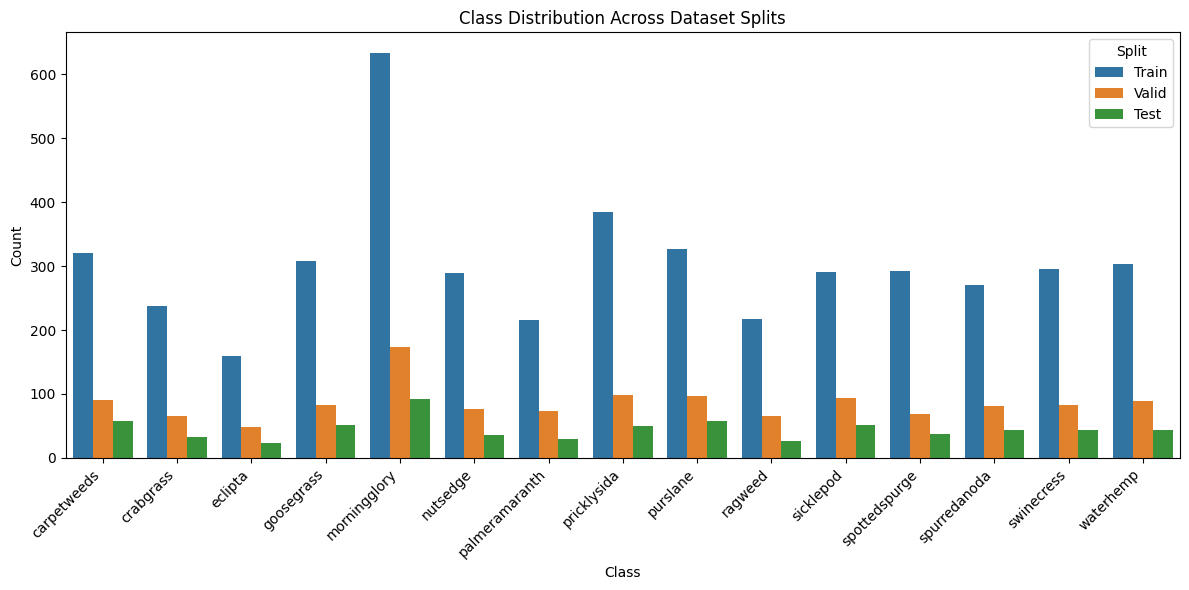

In [10]:
# Analyze dataset statistics
def analyze_dataset(dataset_path):
    # Load class names from data.yaml
    with open(dataset_path / "data.yaml", 'r') as f:
        data_cfg = yaml.safe_load(f)
        class_names = data_cfg['names']

    # Initialize counters
    stats = {
        'train': {'images': 0, 'instances_per_class': {cls: 0 for cls in range(len(class_names))}},
        'valid': {'images': 0, 'instances_per_class': {cls: 0 for cls in range(len(class_names))}},
        'test': {'images': 0, 'instances_per_class': {cls: 0 for cls in range(len(class_names))}}
    }

    # Go through each split
    for split in ['train', 'valid', 'test']:
        label_dir = dataset_path / split / "labels"
        if not os.path.exists(label_dir):
            continue

        # Count images
        stats[split]['images'] = len([f for f in os.listdir(label_dir) if f.endswith('.txt')])

        # Count instances per class
        for label_file in os.listdir(label_dir):
            if not label_file.endswith('.txt'):
                continue

            with open(label_dir / label_file, 'r') as f:
                for line in f:
                    parts = line.strip().split(' ')
                    if len(parts) >= 1:
                        class_id = int(parts[0])
                        if class_id in stats[split]['instances_per_class']:
                            stats[split]['instances_per_class'][class_id] += 1

    # Print statistics
    print("Dataset Statistics:")
    for split, data in stats.items():
        print(f"\n{split.capitalize()} set:")
        print(f"  - Number of images: {data['images']}")
        print("  - Instances per class:")
        for class_id, count in data['instances_per_class'].items():
            if count > 0:  # Only show classes that have instances
                print(f"    - {class_names[class_id]}: {count}")

    # Visualize class distribution
    plt.figure(figsize=(12, 6))

    # Prepare data for plotting
    df_data = []
    for split, data in stats.items():
        for class_id, count in data['instances_per_class'].items():
            if count > 0:  # Only include classes with instances
                df_data.append({
                    'Split': split.capitalize(),
                    'Class': class_names[class_id],
                    'Count': count
                })

    df = pd.DataFrame(df_data)

    # Create grouped bar chart
    sns.barplot(x='Class', y='Count', hue='Split', data=df)
    plt.title('Class Distribution Across Dataset Splits')
    plt.xticks(rotation=45, ha='right')
    plt.tight_layout()
    plt.show()

    # Return statistics for further use
    return stats

# Analyze the dataset
dataset_stats = analyze_dataset(dataset_path)

### 2.3 Data Cleaning, Preprocessing, and Augmentation

Before training, we will:
1. Check for and handle corrupted images
2. Analyze class imbalance and handle it
3. Set up custom data augmentation strategies for weed detection
4. Create a custom YAML file with the optimized configuration

In [11]:
# Function to check for corrupted images
def check_corrupt_images(dataset_path):
    print("Checking for corrupted images...")
    corrupted_count = 0

    for split in ['train', 'valid', 'test']:
        img_dir = dataset_path / split / "images"
        if not os.path.exists(img_dir):
            continue

        print(f"Checking {split} set...")

        for img_file in tqdm(os.listdir(img_dir), desc=f"Checking {split} images"):
            if not img_file.endswith(('.jpg', '.jpeg', '.png')):
                continue

            img_path = img_dir / img_file
            try:
                # Try to open and process the image
                img = cv2.imread(str(img_path))
                if img is None or img.size == 0:
                    print(f"Corrupted image found: {img_path}")
                    corrupted_count += 1
                    continue

                # Check if image is grayscale and convert to RGB if needed
                if len(img.shape) == 2 or img.shape[2] == 1:
                    print(f"Converting grayscale image to RGB: {img_path}")
                    img = cv2.cvtColor(img, cv2.COLOR_GRAY2BGR)
                    cv2.imwrite(str(img_path), img)

                # Check for unusual aspect ratios
                height, width = img.shape[:2]
                aspect_ratio = width / height
                if aspect_ratio > 3 or aspect_ratio < 0.33:
                    print(f"Unusual aspect ratio ({aspect_ratio:.2f}) detected: {img_path}")

            except Exception as e:
                print(f"Error processing {img_path}: {str(e)}")
                corrupted_count += 1

    print(f"Finished checking. Found {corrupted_count} corrupted images.")
    return corrupted_count

# Check for corrupted images
corrupted_count = check_corrupt_images(dataset_path)

Checking for corrupted images...
Checking train set...


Checking train images:   0%|          | 0/3970 [00:00<?, ?it/s]

Checking valid set...


Checking valid images:   0%|          | 0/1127 [00:00<?, ?it/s]

Checking test set...


Checking test images:   0%|          | 0/559 [00:00<?, ?it/s]

Finished checking. Found 0 corrupted images.


In [12]:
# Function to check for inconsistencies between images and labels
def check_label_consistency(dataset_path):
    print("Checking for inconsistencies between images and labels...")
    issue_count = 0

    for split in ['train', 'valid', 'test']:
        img_dir = dataset_path / split / "images"
        label_dir = dataset_path / split / "labels"

        if not os.path.exists(img_dir) or not os.path.exists(label_dir):
            continue

        print(f"Checking {split} set...")

        # Check images without labels
        images = {os.path.splitext(f)[0] for f in os.listdir(img_dir)
                 if f.endswith(('.jpg', '.jpeg', '.png'))}
        labels = {os.path.splitext(f)[0] for f in os.listdir(label_dir)
                 if f.endswith('.txt')}

        img_no_label = images - labels
        if img_no_label:
            print(f"Found {len(img_no_label)} images without labels in {split} set")
            for i, img_name in enumerate(list(img_no_label)[:5]):
                print(f"  {i+1}. {img_name}")
            if len(img_no_label) > 5:
                print(f"  ... and {len(img_no_label) - 5} more")
            issue_count += len(img_no_label)

        # Check labels without images
        label_no_img = labels - images
        if label_no_img:
            print(f"Found {len(label_no_img)} labels without images in {split} set")
            for i, label_name in enumerate(list(label_no_img)[:5]):
                print(f"  {i+1}. {label_name}")
            if len(label_no_img) > 5:
                print(f"  ... and {len(label_no_img) - 5} more")
            issue_count += len(label_no_img)

        # Check for empty label files
        empty_labels = 0
        for label_file in labels:
            label_path = label_dir / f"{label_file}.txt"
            if os.path.exists(label_path) and os.path.getsize(label_path) == 0:
                empty_labels += 1

        if empty_labels > 0:
            print(f"Found {empty_labels} empty label files in {split} set")
            issue_count += empty_labels

    print(f"Finished checking. Found {issue_count} inconsistencies.")
    return issue_count

# Check for label inconsistencies
issue_count = check_label_consistency(dataset_path)

Checking for inconsistencies between images and labels...
Checking train set...
Checking valid set...
Checking test set...
Finished checking. Found 0 inconsistencies.


In [13]:
import os
from pathlib import Path
from tqdm.auto import tqdm # Use tqdm for progress bars

print(f"Searching for empty label files within dataset at: {dataset_path}")

# --- Function to find empty label files ---
def find_empty_labels(base_dataset_path):
    empty_files = []
    for split in ['train', 'valid', 'test']:
        label_dir = Path(base_dataset_path) / split / "labels"
        if not label_dir.exists():
            print(f"Warning: Label directory not found for {split} split: {label_dir}")
            continue

        for label_file in label_dir.glob("*.txt"):
            try:
                # Check if file size is 0 bytes
                if label_file.stat().st_size == 0:
                    empty_files.append(label_file)
            except Exception as e:
                print(f"Warning: Could not check size of {label_file}: {e}")
    return empty_files

# --- Find the empty files ---
empty_label_paths = find_empty_labels(dataset_path)

if not empty_label_paths:
    print("No empty label files found. No removal needed.")
else:
    print(f"Found {len(empty_label_paths)} empty label files. Proceeding with removal...")
    print("Empty files found:")
    for p in empty_label_paths:
        print(f"- {p}")

    # --- Function to remove labels and corresponding images ---
    def remove_empty_labels_and_images(label_paths_to_remove):
        removed_labels_count = 0
        removed_images_count = 0
        label_errors = []
        image_errors = []

        print("\nStarting removal process...")
        for label_path in tqdm(label_paths_to_remove, desc="Removing files"):
            # --- Remove Label File ---
            if label_path.exists():
                try:
                    os.remove(label_path)
                    # print(f"Removed empty label file: {label_path}") # Optional: less verbose
                    removed_labels_count += 1
                except Exception as e:
                    error_msg = f"Failed to remove label {label_path}: {e}"
                    print(error_msg)
                    label_errors.append(error_msg)
                    continue # Skip image removal if label removal failed
            else:
                # This case shouldn't happen if find_empty_labels worked correctly
                print(f"Label file not found (already removed?): {label_path}")
                continue

            # --- Find and Remove Corresponding Image File ---
            label_filename_base = label_path.stem # Get filename without .txt
            # Construct path relative to dataset_path structure
            image_dir = label_path.parent.parent / "images"

            image_found_and_removed = False
            for ext in ['.jpg', '.jpeg', '.png', '.JPG', '.JPEG', '.PNG']: # Check common extensions (case-insensitive)
                image_path = image_dir / f"{label_filename_base}{ext}"
                if image_path.exists():
                    try:
                        os.remove(image_path)
                        # print(f"-> Removed corresponding image file: {image_path}") # Optional: less verbose
                        removed_images_count += 1
                        image_found_and_removed = True
                        break # Stop looking once found and removed
                    except Exception as e:
                         error_msg = f"-> Failed to remove image {image_path}: {e}"
                         print(error_msg)
                         image_errors.append(error_msg)
                         break # Stop trying for this image if error occurs

            if not image_found_and_removed:
                 warn_msg = f"-> Warning: Could not find corresponding image for {label_path.name} in {image_dir}"
                 print(warn_msg)
                 image_errors.append(warn_msg)

        # --- Print Summary ---
        print(f"\n--- Removal Summary ---")
        print(f"Attempted removal for {len(label_paths_to_remove)} empty label files.")
        print(f"Successfully removed labels: {removed_labels_count}")
        print(f"Successfully removed corresponding images: {removed_images_count}")
        if label_errors:
            print(f"\nErrors removing labels ({len(label_errors)}):")
            for err in label_errors[:5]: print(f"  - {err}") # Print first 5 errors
            if len(label_errors) > 5: print("  ...")
        if image_errors:
            print(f"\nErrors/Warnings finding/removing images ({len(image_errors)}):")
            for err in image_errors[:5]: print(f"  - {err}") # Print first 5 errors/warnings
            if len(image_errors) > 5: print("  ...")
        print("--- End of Summary ---")

    # --- Execute the removal ---
    remove_empty_labels_and_images(empty_label_paths)


Searching for empty label files within dataset at: /kaggle/working/weed_detection-6
No empty label files found. No removal needed.


In [14]:
# Function to handle class imbalance
def handle_class_imbalance(dataset_path, dataset_stats):
    print("Analyzing class imbalance...")

    # Load class names from data.yaml
    with open(dataset_path / "data.yaml", 'r') as f:
        data_cfg = yaml.safe_load(f)
        class_names = data_cfg['names']

    # Get class distribution in training set
    train_instances = dataset_stats['train']['instances_per_class']

    # Sort classes by number of instances
    sorted_classes = sorted(train_instances.items(), key=lambda x: x[1])

    # Identify minority and majority classes
    minority_classes = []
    majority_classes = []

    # Get the mean number of instances per class
    mean_instances = sum(train_instances.values()) / len(train_instances)
    print(f"Mean instances per class: {mean_instances:.2f}")

    for class_id, count in sorted_classes:
        class_name = class_names[class_id]
        if count < 0.5 * mean_instances:
            minority_classes.append((class_id, class_name, count))
        elif count > 1.5 * mean_instances:
            majority_classes.append((class_id, class_name, count))

    print("\nMinority classes (below 50% of mean):")
    for class_id, class_name, count in minority_classes:
        print(f"  - {class_name}: {count} instances ({count/mean_instances:.2f}x mean)")

    print("\nMajority classes (above 150% of mean):")
    for class_id, class_name, count in majority_classes:
        print(f"  - {class_name}: {count} instances ({count/mean_instances:.2f}x mean)")

    # Calculate class weights for loss function
    max_instances = max(train_instances.values())
    class_weights = {class_id: max_instances / max(1, count) for class_id, count in train_instances.items()}

    print("\nCalculated class weights for loss function:")
    for class_id, weight in class_weights.items():
        print(f"  - {class_names[class_id]}: {weight:.2f}")

    # Return class weights dictionary for use during training
    return {
        'minority_classes': minority_classes,
        'majority_classes': majority_classes,
        'class_weights': class_weights
    }

# Handle class imbalance
imbalance_info = handle_class_imbalance(dataset_path, dataset_stats)

Analyzing class imbalance...
Mean instances per class: 303.27

Minority classes (below 50% of mean):

Majority classes (above 150% of mean):
  - morningglory: 634 instances (2.09x mean)

Calculated class weights for loss function:
  - carpetweeds: 1.98
  - crabgrass: 2.66
  - eclipta: 3.96
  - goosegrass: 2.06
  - morningglory: 1.00
  - nutsedge: 2.19
  - palmeramaranth: 2.94
  - pricklysida: 1.65
  - purslane: 1.94
  - ragweed: 2.91
  - sicklepod: 2.18
  - spottedspurge: 2.16
  - spurredanoda: 2.35
  - swinecress: 2.14
  - waterhemp: 2.09


In [15]:
# Define custom data augmentation strategies for weed segmentation
def create_augmentation_config(dataset_path, imbalance_info):
    print("Creating custom data augmentation configuration...")

    # Load the original YAML config
    data_yaml_path = dataset_path / "data.yaml"
    with open(data_yaml_path, 'r') as f:
        data_cfg = yaml.safe_load(f)

    # Create a custom YAML configuration with augmentations
    augmented_cfg = data_cfg.copy()

    # Define stronger augmentation for minority classes
    minority_class_ids = [c[0] for c in imbalance_info['minority_classes']]

    # Advanced augmentation config for YOLOv8
    augmented_cfg['augment'] = True

    # YOLOv8 hyperparameters with augmentation settings
    augmented_cfg['hyp'] = {
        # Augmentation probabilities and parameters
        'mosaic': 1.0,           # Mosaic augmentation probability
        'mixup': 0.2,            # Mixup augmentation probability
        'copy_paste': 0.3,       # Copy-paste augmentation probability (good for instances)
        'degrees': 20.0,         # Rotation augmentation degrees
        'translate': 0.2,        # Translation augmentation magnitude
        'scale': 0.2,            # Scale augmentation magnitude
        'shear': 0.2,            # Shear augmentation magnitude
        'perspective': 0.0,      # Perspective augmentation magnitude (reduce for close-up weed images)
        'flipud': 0.1,           # Vertical flip probability
        'fliplr': 0.5,           # Horizontal flip probability
        'hsv_h': 0.015,          # HSV hue augmentation magnitude
        'hsv_s': 0.2,            # HSV saturation augmentation magnitude
        'hsv_v': 0.2,            # HSV value augmentation magnitude (brightness)

        # Training hyperparameters (will be overridden by train function params)
        'lr0': 0.001,
        'weight_decay': 0.0005,
        'warmup_epochs': 3.0,
        'warmup_momentum': 0.8,
        'warmup_bias_lr': 0.1,
        'box': 7.5,              # Box loss weight
        'cls': 0.5,              # Class loss weight
        'dfl': 1.5,              # Distribution focal loss weight
        'masks': 1.0,            # Mask loss weight (important for segmentation)
    }

    # Set class weights to handle class imbalance
    class_weights = imbalance_info['class_weights']
    # Normalize weights to be centered around 1
    avg_weight = sum(class_weights.values()) / len(class_weights)
    normalized_weights = {str(k): v / avg_weight for k, v in class_weights.items()}

    augmented_cfg['class_weights'] = normalized_weights

    # Save the augmented config
    augmented_yaml_path = dataset_path / "data_augmented.yaml"
    with open(augmented_yaml_path, 'w') as f:
        yaml.dump(augmented_cfg, f, default_flow_style=False)

    print(f"Created augmented configuration at: {augmented_yaml_path}")
    return augmented_yaml_path

# Create augmentation configuration
augmented_data_yaml = create_augmentation_config(dataset_path, imbalance_info)

Creating custom data augmentation configuration...
Created augmented configuration at: /kaggle/working/weed_detection-6/data_augmented.yaml


Visualizing data augmentation effects...


A new version of Albumentations is available: 2.0.5 (you have 1.4.20). Upgrade using: pip install -U albumentations. To disable automatic update checks, set the environment variable NO_ALBUMENTATIONS_UPDATE to 1.


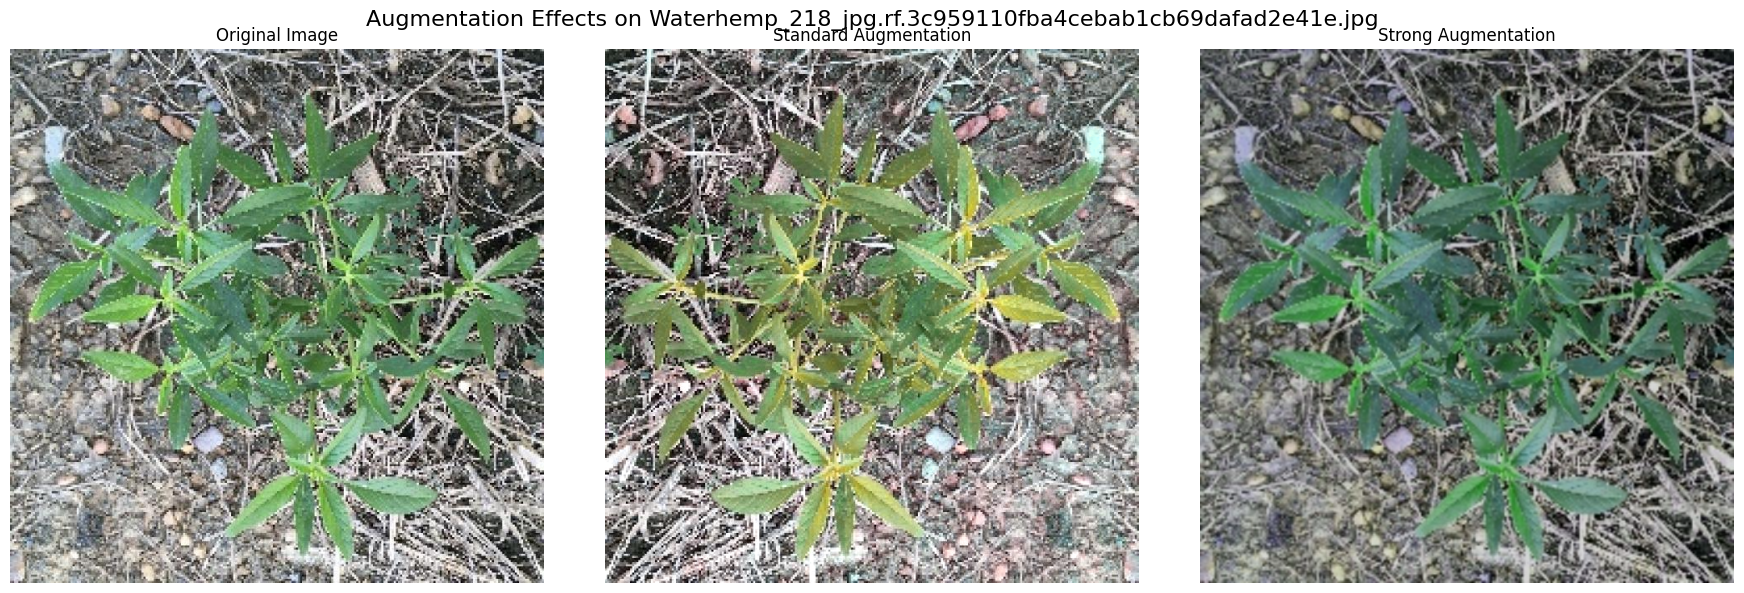

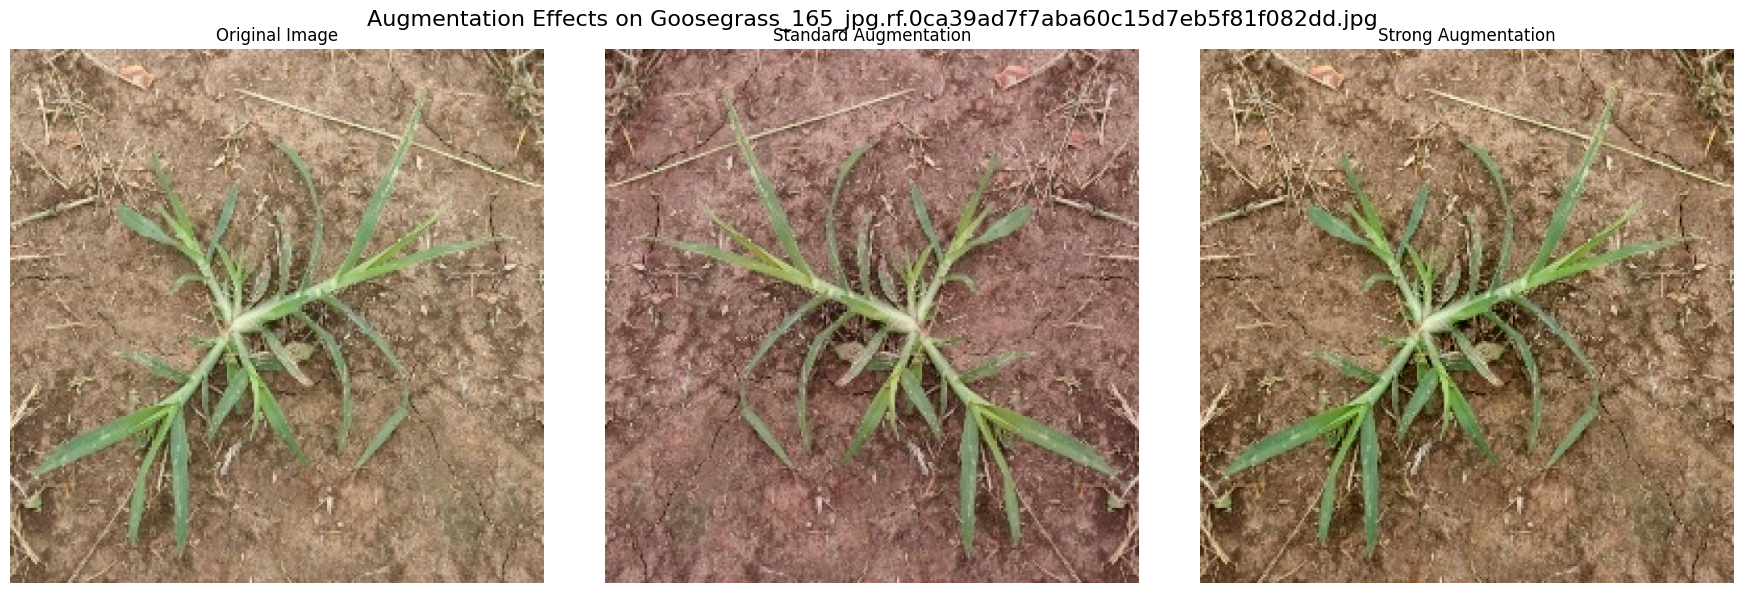

In [16]:
# Function to visualize the effects of data augmentation
def visualize_augmentation(dataset_path, num_samples=3):
    print("Visualizing data augmentation effects...")

    # Get a few sample images from training set
    train_img_dir = dataset_path / "train" / "images"
    if not os.path.exists(train_img_dir):
        print("Training image directory not found!")
        return

    image_files = [f for f in os.listdir(train_img_dir) if f.endswith(('.jpg', '.jpeg', '.png'))]
    if len(image_files) == 0:
        print("No training images found!")
        return

    # Randomly sample images
    sample_images = random.sample(image_files, min(num_samples, len(image_files)))

    # Initialize transforms
    import albumentations as A
    from albumentations.pytorch import ToTensorV2

    # Define standard augmentation pipeline
    standard_augs = A.Compose([
        A.HorizontalFlip(p=0.5),
        A.ColorJitter(brightness=0.1, contrast=0.1, saturation=0.1, hue=0.1, p=0.8),
    ])

    # Define stronger augmentation pipeline
    strong_augs = A.Compose([
        A.HorizontalFlip(p=0.5),
        A.RandomRotate90(p=0.5),
        A.ShiftScaleRotate(shift_limit=0.2, scale_limit=0.2, rotate_limit=20, p=0.7),
        A.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2, hue=0.1, p=0.8),
        A.Blur(blur_limit=3, p=0.3),
        A.RandomBrightnessContrast(brightness_limit=0.2, contrast_limit=0.2, p=0.5),
        A.GaussNoise(var_limit=(10, 50), p=0.3),
    ])

    # Visualize each sample with different augmentations
    for img_file in sample_images:
        img_path = train_img_dir / img_file

        # Read image
        img = cv2.imread(str(img_path))
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

        # Create augmented versions
        aug_standard = standard_augs(image=img)['image']
        aug_strong = strong_augs(image=img)['image']

        # Display original and augmented
        fig, axes = plt.subplots(1, 3, figsize=(18, 6))

        axes[0].imshow(img)
        axes[0].set_title("Original Image")
        axes[0].axis('off')

        axes[1].imshow(aug_standard)
        axes[1].set_title("Standard Augmentation")
        axes[1].axis('off')

        axes[2].imshow(aug_strong)
        axes[2].set_title("Strong Augmentation")
        axes[2].axis('off')

        plt.suptitle(f"Augmentation Effects on {img_file}", fontsize=16)
        plt.tight_layout()
        plt.show()

# Install albumentations for visualization
!pip install -q albumentations

# Visualize augmentation effects
visualize_augmentation(dataset_path, num_samples=2)

In [17]:
# Function to create a preprocessing summary
def create_preprocessing_summary(dataset_path, corrupted_count, issue_count, imbalance_info):
    print("\n=============================================")
    print("DATA PREPROCESSING SUMMARY")
    print("=============================================\n")

    # Dataset overview
    print("Dataset Location:", dataset_path)

    # Load class names from data.yaml
    # Assumes yaml was imported globally earlier
    # import yaml
    with open(dataset_path / "data.yaml", 'r') as f:
        data_cfg = yaml.safe_load(f)
        class_names = data_cfg['names']

    print(f"Number of Classes: {len(class_names)}")
    print(f"Classes: {', '.join(class_names)}")

    # Data cleaning results
    print("\nData Cleaning Results:")
    print(f"  - Corrupted Images Checked: {corrupted_count} found (Note: Function attempts conversion/prints warnings)")
    print(f"  - Label Inconsistencies Checked: {issue_count} found (Note: Function reports counts)")

    # Class imbalance summary
    print("\nClass Imbalance Summary:")
    if imbalance_info['minority_classes']:
        print(f"  - Minority Classes (below 50% mean instances): {len(imbalance_info['minority_classes'])}")
        for _, name, count in imbalance_info['minority_classes']:
            print(f"    * {name}: {count} instances")
    else:
        print("  - No significant minority classes identified based on threshold.")

    if imbalance_info['majority_classes']:
         print(f"  - Majority Classes (above 150% mean instances): {len(imbalance_info['majority_classes'])}")
         for _, name, count in imbalance_info['majority_classes']:
             print(f"    * {name}: {count} instances")
    else:
         print("  - No significant majority classes identified based on threshold.")


    # Augmentation strategy (as configured in YAML)
    print("\nAugmentation Strategy (Enabled in data_augmented.yaml):")
    print("  - Augmentations like mosaic, mixup, copy-paste, flips, color jitter, etc., are probabilistically applied during training based on hyperparameters.")
    print("  - While helpful for imbalance, these augmentations are generally applied across batches, not exclusively targeted to minority class instances within the standard training loop.")
    print("  - Class weights were calculated and included in the configuration to directly address imbalance during loss calculation.")

    # Final dataset configuration
    print("\nFinal Dataset Configuration:")
    print(f"  - Augmented config file used for training: data_augmented.yaml")
    print(f"  - Class weights applied via config: {bool(imbalance_info['class_weights'])}")

    print("\nPreprocessing checks completed. Ready for model training.")

# Create preprocessing summary
# Make sure the input variables (dataset_path, corrupted_count, issue_count, imbalance_info) exist
try:
    # Assumes yaml package was imported in a previous cell
    create_preprocessing_summary(dataset_path, corrupted_count, issue_count, imbalance_info)
except NameError as e:
    # This error message is intentional if prerequisite cells haven't been run
    print(f"Error creating summary: Make sure all required variables are defined. Missing variable: {e.name}")
except ImportError:
    print("Error: The 'yaml' package needs to be imported. Please ensure PyYAML is installed and imported in a previous cell.")



DATA PREPROCESSING SUMMARY

Dataset Location: /kaggle/working/weed_detection-6
Number of Classes: 15
Classes: carpetweeds, crabgrass, eclipta, goosegrass, morningglory, nutsedge, palmeramaranth, pricklysida, purslane, ragweed, sicklepod, spottedspurge, spurredanoda, swinecress, waterhemp

Data Cleaning Results:
  - Corrupted Images Checked: 0 found (Note: Function attempts conversion/prints warnings)
  - Label Inconsistencies Checked: 0 found (Note: Function reports counts)

Class Imbalance Summary:
  - No significant minority classes identified based on threshold.
  - Majority Classes (above 150% mean instances): 1
    * morningglory: 634 instances

Augmentation Strategy (Enabled in data_augmented.yaml):
  - Augmentations like mosaic, mixup, copy-paste, flips, color jitter, etc., are probabilistically applied during training based on hyperparameters.
  - While helpful for imbalance, these augmentations are generally applied across batches, not exclusively targeted to minority class i

### 2.3.3 Validate Polygon Geometry and Remove Invalid Labels/Images

Even if label files exist and are non-empty, they might contain invalid polygon definitions (e.g., self-intersecting, too few points, collapsed area) which can cause errors during segmentation training. This step uses the `shapely` library to validate polygon geometry.

**Action:**
- Scans all `.txt` label files in `train`, `valid`, and `test` splits.
- Identifies files containing one or more invalid or near-zero area polygons.
- **Automatically DELETES** these problematic label files **AND** their corresponding image files.

**⚠️ Warning:** This step modifies your dataset by deleting files. Ensure you have a backup or can easily re-download the dataset if needed.

In [18]:
# === Step 2.3.3: Validate Polygon Geometry & Remove Invalid Data ===

# --- Ensure Shapely is installed ---
try:
    from shapely.geometry import Polygon
    from shapely.errors import GEOSException
    print("Shapely is already installed.")
except ImportError:
    print("Installing Shapely for polygon validation...")
    !pip install shapely -q
    from shapely.geometry import Polygon
    from shapely.errors import GEOSException
    print("Shapely installed.")

import os
import yaml
from pathlib import Path
from tqdm.auto import tqdm

print(f"\nStarting polygon validation & removal for dataset: {dataset_path}")
print("WARNING: This will DELETE label files with invalid polygons AND their corresponding images.")

# --- Configuration ---
num_classes = None # Initialize
try:
    # Load nc from the most relevant YAML (augmented if exists, else original)
    data_yaml_to_check = dataset_path / "data_augmented.yaml"
    if not data_yaml_to_check.exists():
        data_yaml_to_check = dataset_path / "data.yaml"

    if data_yaml_to_check.exists():
         with open(data_yaml_to_check, 'r') as f:
             data_cfg = yaml.safe_load(f)
             if 'nc' in data_cfg:
                  num_classes = int(data_cfg['nc'])
                  print(f"Number of classes from {data_yaml_to_check.name}: {num_classes}")
             else: print("Warning: 'nc' not found in YAML.")
    else: print(f"Warning: YAML file not found at {data_yaml_to_check}")
except Exception as e: print(f"Warning: Error loading YAML: {e}")

# --- Validation Function (returns True if issues found) ---
def check_file_for_geometry_issues(filepath, num_classes):
    """Checks a label file for empty status or invalid polygon geometry."""
    if not filepath.exists() or filepath.stat().st_size == 0: return True # Empty or missing

    try:
        with open(filepath, 'r') as f: lines = f.readlines()
        if not lines: return True # No lines

        for i, line in enumerate(lines):
            parts = line.strip().split()
            if not parts: continue

            if len(parts) < 7 or len(parts) % 2 != 1: return True # Basic format issue

            # Validate Class ID
            try:
                class_id = int(parts[0])
                if num_classes is not None and not (0 <= class_id < num_classes): return True
            except ValueError: return True # Class ID not integer

            # Validate Coordinates & Geometry
            coords = []
            for j in range(1, len(parts), 2):
                try:
                    x = float(parts[j]); y = float(parts[j+1])
                    coords.append((x, y))
                except (ValueError, IndexError): return True # Coord not number or pair missing

            if len(coords) < 3: return True # Not enough points

            try:
                polygon = Polygon(coords)
                area_threshold = 1e-7 # Threshold for collapsed polygon
                if not polygon.is_valid or polygon.area < area_threshold: return True # Invalid geometry or area
            except (GEOSException, ValueError, Exception): return True # Error creating polygon

    except Exception: return True # Issue reading file
    return False # No issues found

# --- Find Files with Issues ---
files_to_remove = []
print("\nScanning files for geometry issues...")
for split in ['train', 'valid', 'test']:
    label_dir = dataset_path / split / "labels"
    if not label_dir.exists(): continue

    print(f"Scanning {split} labels...")
    current_split_files = list(label_dir.glob("*.txt"))
    if not current_split_files: continue

    for label_file in tqdm(current_split_files, desc=f"Scanning {split}"):
        if check_file_for_geometry_issues(label_file, num_classes):
            files_to_remove.append(label_file)

print(f"\nScan complete. Found {len(files_to_remove)} label files flagged for removal (empty or invalid geometry).")

# --- Automated Removal ---
if files_to_remove:
    print(f"\nProceeding to remove {len(files_to_remove)} label files and their corresponding images...")
    removed_labels_count = 0
    removed_images_count = 0
    errors = []

    for label_path in tqdm(files_to_remove, desc="Removing files"):
        label_removed = False
        # Remove Label
        try:
            if label_path.exists():
                os.remove(label_path)
                removed_labels_count += 1
                label_removed = True
        except Exception as e: errors.append(f"Label {label_path}: {e}")

        # Find and Remove Corresponding Image
        if label_removed:
            label_filename_base = label_path.stem
            image_dir = label_path.parent.parent / "images"
            image_found = False
            for ext in ['.jpg', '.jpeg', '.png', '.JPG', '.JPEG', '.PNG']:
                image_path = image_dir / f"{label_filename_base}{ext}"
                if image_path.exists():
                    image_found = True
                    try:
                        os.remove(image_path)
                        removed_images_count += 1
                        break
                    except Exception as e:
                        errors.append(f"Image {image_path}: {e}")
                        break
            # Optional: Add warning if image not found, but can be noisy
            # if not image_found: errors.append(f"Warning: Image not found for {label_path.name}")

    # --- Removal Summary ---
    print(f"\n--- Removal Summary ---")
    print(f"Labels removed: {removed_labels_count}/{len(files_to_remove)}")
    print(f"Images removed: {removed_images_count}")
    if errors:
        print(f"Encountered {len(errors)} errors/warnings (showing first 5):")
        for i, err in enumerate(errors[:5]): print(f"  - {err}")
else:
    print("No files needed removal based on geometry checks.")

print("\n--- Polygon Validation and Automated Removal Process Complete ---")

# Optional: Re-run the dataset analysis cell to see updated counts
# print("\nRe-running dataset analysis after cleaning...")
# try:
#     dataset_stats = analyze_dataset(dataset_path)
# except NameError:
#     print("analyze_dataset function not defined or dataset_path missing.")


Shapely is already installed.

Starting polygon validation & removal for dataset: /kaggle/working/weed_detection-6
Number of classes from data_augmented.yaml: 15

Scanning files for geometry issues...
Scanning train labels...


Scanning train:   0%|          | 0/3970 [00:00<?, ?it/s]

Scanning valid labels...


Scanning valid:   0%|          | 0/1127 [00:00<?, ?it/s]

Scanning test labels...


Scanning test:   0%|          | 0/559 [00:00<?, ?it/s]


Scan complete. Found 0 label files flagged for removal (empty or invalid geometry).
No files needed removal based on geometry checks.

--- Polygon Validation and Automated Removal Process Complete ---


## 3. Modeling with YOLOv8

### 3.1 Model Selection and Configuration

In [19]:
# Check YOLOv8 available models
print("Available YOLOv8 segmentation models:")
print("- yolov8n-seg.pt (smallest, fastest)")
print("- yolov8s-seg.pt (small)")
print("- yolov8m-seg.pt (medium)")
print("- yolov8l-seg.pt (large)")
print("- yolov8x-seg.pt (extra large, most accurate)")

# Select model based on your system's capabilities
# Start with a smaller model like yolov8s-seg.pt for faster training
MODEL_NAME = "yolov8s-seg.pt"

# Load a pre-trained YOLOv8 segmentation model
model = YOLO(MODEL_NAME)
print(f"\nLoaded {MODEL_NAME} model")

Available YOLOv8 segmentation models:
- yolov8n-seg.pt (smallest, fastest)
- yolov8s-seg.pt (small)
- yolov8m-seg.pt (medium)
- yolov8l-seg.pt (large)
- yolov8x-seg.pt (extra large, most accurate)

Loaded yolov8s-seg.pt model


In [20]:
# Create a project directory for output
project_dir = Path("./weed_detection_yolov8")
os.makedirs(project_dir, exist_ok=True)
print(f"Project directory: {project_dir}")

# Use our augmented data.yaml instead of the original one
data_yaml_path = augmented_data_yaml
print(f"Using augmented configuration: {data_yaml_path}")

Project directory: weed_detection_yolov8
Using augmented configuration: /kaggle/working/weed_detection-6/data_augmented.yaml


### 3.2 Model Training

In [ ]:
import torch # Ensure torch is imported
# Assuming model, data_yaml_path, project_dir are defined earlier in your notebook

print("Attempting training with reduced resource settings and tuning...")

# --- Troubleshooting & Tuning Settings ---
# Reduced batch size (8) and workers (2).
# Disabled RAM caching (cache=False).
# Using AdamW optimizer.
# Slightly increased mask_ratio to prioritize segmentation loss.
# Early Stopping: Controlled by 'patience' (stops if no improvement in val loss for 'patience' epochs).
#
# If loss is still high or training stops:
#   - Further reduce 'batch' (e.g., 4).
#   - Reduce 'imgsz' (e.g., 512).
#   - Adjust 'lr0' (e.g., 0.0005) or 'weight_decay' (e.g., 0.0001).
#   - Increase 'epochs' if early stopping occurs too soon.
#   - Increase 'patience' if stopping too early despite fluctuations.
#   - Increase 'mask_ratio' further (e.g., 6, 7) if seg_loss is disproportionately high.
#   - Try a larger model ('yolov8m-seg.pt') if resources allow.
#   - Set 'augment=False' temporarily to isolate augmentation issues.
# ------------------------------------------

# Determine device setting based on GPU availability
if torch.cuda.is_available() and torch.cuda.device_count() >= 2:
    device_setting = [0, 1]
    print(f"Configured to use GPUs: {device_setting}")
    batch_size = 8 # TRY EVEN SMALLER (e.g., 4) IF IT STILL CRASHES
else:
    device_setting = 0 if torch.cuda.is_available() else 'cpu'
    print(f"Less than 2 GPUs detected. Using device: {device_setting}")
    batch_size = 8 # TRY EVEN SMALLER (e.g., 4) IF IT STILL CRASHES

num_workers = 2 # Reduced number of workers
initial_patience = 15 # Increased patience slightly
print(f"Using batch size: {batch_size}, workers: {num_workers}, patience: {initial_patience}")

results = model.train(
    data=str(data_yaml_path),
    epochs=50,                  # Initial epochs
    imgsz=640,
    batch=batch_size,           # USE REDUCED BATCH SIZE
    patience=initial_patience,  # EARLY STOPPING PATIENCE
    device=device_setting,
    project=str(project_dir),
    name="weed_segmentation_tuned_v1", # New run name
    pretrained=True,
    optimizer='AdamW',          # USING AdamW
    lr0=0.001,                  # Initial learning rate
    weight_decay=0.0005,        # Default weight decay
    single_cls=False,
    dropout=0.0,
    augment=True,
    cache=False,                # DISABLED RAM CACHING
    verbose=True,
    amp=True,
    close_mosaic=10,
    cos_lr=True,
    overlap_mask=True,
    mask_ratio=5,               # INCREASED MASK LOSS WEIGHT (default is 4, must be int)
    task='segment',
    workers=num_workers         # USE REDUCED WORKERS
)
print("Training function called. Monitor progress and resource usage.")

Attempting training...
Less than 2 GPUs detected. Using device: 0
Ultralytics 8.3.109 🚀 Python-3.10.12 torch-2.5.1+cu121 CUDA:0 (Tesla P100-PCIE-16GB, 16269MiB)
engine/trainer: task=segment, mode=train, model=yolov8s-seg.pt, data=/kaggle/working/weed_detection-6/data_augmented.yaml, epochs=50, time=None, patience=10, batch=16, imgsz=640, save=True, save_period=-1, cache=ram, device=0, workers=8, project=weed_detection_yolov8, name=weed_segmentation_debug_multi_gpu2, exist_ok=False, pretrained=True, optimizer=Adam, verbose=True, seed=0, deterministic=True, single_cls=False, rect=False, cos_lr=True, close_mosaic=0, resume=False, amp=True, fraction=1.0, profile=False, freeze=None, multi_scale=False, overlap_mask=True, mask_ratio=4, dropout=0.0, val=True, split=val, save_json=False, conf=None, iou=0.7, max_det=300, half=False, dnn=False, plots=True, source=None, vid_stride=1, stream_buffer=False, visualize=False, augment=True, agnostic_nms=False, classes=None, retina_masks=False, embed=Non

100%|██████████| 755k/755k [00:00<00:00, 24.1MB/s]


Overriding model.yaml nc=80 with nc=15

                   from  n    params  module                                       arguments                     
  0                  -1  1       928  ultralytics.nn.modules.conv.Conv             [3, 32, 3, 2]                 
  1                  -1  1     18560  ultralytics.nn.modules.conv.Conv             [32, 64, 3, 2]                
  2                  -1  1     29056  ultralytics.nn.modules.block.C2f             [64, 64, 1, True]             
  3                  -1  1     73984  ultralytics.nn.modules.conv.Conv             [64, 128, 3, 2]               
  4                  -1  2    197632  ultralytics.nn.modules.block.C2f             [128, 128, 2, True]           
  5                  -1  1    295424  ultralytics.nn.modules.conv.Conv             [128, 256, 3, 2]              
  6                  -1  2    788480  ultralytics.nn.modules.block.C2f             [256, 256, 2, True]           
  7                  -1  1   1180672  ultralytic

train: Scanning /kaggle/working/weed_detection-6/train/labels.cache... 3970 images, 0 backgrounds, 0 corrupt: 100%|██████████| 3970/3970 [00:00<?, ?it/s]

train: WARNING ⚠️ /kaggle/working/weed_detection-6/train/images/Prickly-Sida_augmented_61_1_jpg.rf.647ada7fea38276898e907a2e1fa9428.jpg: 1 duplicate labels removed
WARNING ⚠️ cache='ram' may produce non-deterministic training results. Consider cache='disk' as a deterministic alternative if your disk space allows.



train: Caching images (4.5GB RAM): 100%|██████████| 3970/3970 [00:05<00:00, 711.03it/s]

albumentations: Blur(p=0.01, blur_limit=(3, 7)), MedianBlur(p=0.01, blur_limit=(3, 7)), ToGray(p=0.01, num_output_channels=3, method='weighted_average'), CLAHE(p=0.01, clip_limit=(1.0, 4.0), tile_grid_size=(8, 8))



val: Scanning /kaggle/working/weed_detection-6/valid/labels.cache... 1127 images, 0 backgrounds, 0 corrupt: 100%|██████████| 1127/1127 [00:00<?, ?it/s]


WARNING ⚠️ cache='ram' may produce non-deterministic training results. Consider cache='disk' as a deterministic alternative if your disk space allows.


val: Caching images (1.3GB RAM): 100%|██████████| 1127/1127 [00:02<00:00, 383.76it/s]


Plotting labels to weed_detection_yolov8/weed_segmentation_debug_multi_gpu2/labels.jpg... 
optimizer: Adam(lr=0.001, momentum=0.937) with parameter groups 66 weight(decay=0.0), 77 weight(decay=0.0005), 76 bias(decay=0.0)
TensorBoard: model graph visualization added ✅
Image sizes 640 train, 640 val
Using 4 dataloader workers
Logging results to weed_detection_yolov8/weed_segmentation_debug_multi_gpu2
Starting training for 50 epochs...

      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


       1/50       1.9G     0.9965      2.578      1.715      1.461         11        640: 100%|██████████| 249/249 [02:13<00:00,  1.86it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 36/36 [00:25<00:00,  1.44it/s]

                   all       1127       1290      0.317      0.489      0.298      0.201       0.13      0.174     0.0689     0.0201



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


       2/50      5.13G     0.9351       2.17      1.164      1.403          3        640: 100%|██████████| 249/249 [01:39<00:00,  2.49it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 36/36 [00:13<00:00,  2.65it/s]


                   all       1127       1290      0.355      0.468      0.325      0.243      0.335      0.441      0.284      0.138

      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


       3/50      5.13G     0.9174      2.121      1.094      1.384          5        640: 100%|██████████| 249/249 [01:39<00:00,  2.51it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 36/36 [00:13<00:00,  2.62it/s]


                   all       1127       1290      0.348       0.52       0.36      0.251      0.325      0.504      0.329      0.173

      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


       4/50      5.13G     0.8696      2.072      1.032      1.351          8        640: 100%|██████████| 249/249 [01:39<00:00,  2.51it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 36/36 [00:14<00:00,  2.55it/s]


                   all       1127       1290      0.315      0.472      0.331       0.22      0.295      0.437      0.293       0.15

      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


       5/50      5.13G     0.8282      2.013     0.9473      1.316          5        640: 100%|██████████| 249/249 [01:39<00:00,  2.49it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 36/36 [00:13<00:00,  2.67it/s]


                   all       1127       1290      0.405      0.552      0.437      0.314      0.389      0.532      0.406      0.213

      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


       6/50      5.13G     0.7968       1.95     0.9096      1.295          5        640: 100%|██████████| 249/249 [01:39<00:00,  2.51it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 36/36 [00:13<00:00,  2.61it/s]


                   all       1127       1290      0.476      0.541      0.483      0.364      0.445      0.484      0.427      0.211

      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


       7/50      5.13G     0.7726      1.937     0.8924      1.273          5        640: 100%|██████████| 249/249 [01:38<00:00,  2.52it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 36/36 [00:13<00:00,  2.74it/s]

                   all       1127       1290      0.493      0.592      0.516      0.397      0.453      0.544      0.459      0.245



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


       8/50      5.13G     0.7465      1.896     0.8437      1.257          3        640: 100%|██████████| 249/249 [01:38<00:00,  2.53it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 36/36 [00:13<00:00,  2.67it/s]


                   all       1127       1290      0.541      0.563      0.546      0.422      0.526      0.543      0.519      0.296

      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


       9/50      5.13G     0.7233      1.849     0.7872      1.238          4        640: 100%|██████████| 249/249 [01:37<00:00,  2.55it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 36/36 [00:12<00:00,  2.79it/s]

                   all       1127       1290      0.529      0.655      0.592      0.441      0.519      0.643      0.574      0.333



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


      10/50      5.13G     0.6938        1.8     0.7597      1.215          5        640: 100%|██████████| 249/249 [01:38<00:00,  2.54it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 36/36 [00:13<00:00,  2.74it/s]


                   all       1127       1290      0.591      0.588      0.602      0.482      0.574      0.563       0.57      0.314

      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


      11/50      5.13G     0.6798      1.794     0.7528      1.203          7        640: 100%|██████████| 249/249 [01:38<00:00,  2.54it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 36/36 [00:13<00:00,  2.73it/s]


                   all       1127       1290      0.619      0.603      0.627      0.484      0.602      0.586      0.602      0.339

      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


      12/50      5.13G     0.6533      1.721     0.7207      1.194          3        640: 100%|██████████| 249/249 [01:38<00:00,  2.54it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 36/36 [00:13<00:00,  2.72it/s]


                   all       1127       1290      0.596      0.623      0.619      0.475      0.582      0.603      0.588      0.336

      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


      13/50      5.13G     0.6492      1.711     0.7169      1.186          5        640: 100%|██████████| 249/249 [01:37<00:00,  2.55it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 36/36 [00:12<00:00,  2.85it/s]

                   all       1127       1290      0.579      0.619      0.625      0.503      0.567        0.6      0.598      0.336



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


      14/50      5.13G     0.6262      1.678     0.6857      1.166          6        640: 100%|██████████| 249/249 [01:37<00:00,  2.55it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 36/36 [00:13<00:00,  2.62it/s]


                   all       1127       1290      0.635      0.629      0.663      0.489      0.619      0.608      0.641      0.367

      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


      15/50      5.13G     0.6254      1.653     0.6683      1.169          8        640: 100%|██████████| 249/249 [01:40<00:00,  2.49it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 36/36 [00:13<00:00,  2.57it/s]


                   all       1127       1290      0.597      0.648      0.666      0.534      0.583       0.63      0.637      0.372

      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


      16/50      5.13G     0.6164      1.652     0.6675       1.16          6        640: 100%|██████████| 249/249 [01:39<00:00,  2.49it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 36/36 [00:14<00:00,  2.57it/s]


                   all       1127       1290      0.713      0.662      0.735      0.588      0.694       0.64        0.7      0.417

      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


      17/50      5.13G     0.5939      1.584     0.6321      1.148          8        640: 100%|██████████| 249/249 [01:39<00:00,  2.51it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 36/36 [00:13<00:00,  2.65it/s]

                   all       1127       1290       0.69      0.653      0.704      0.571       0.68      0.636      0.678      0.395



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


      18/50      5.13G     0.5857      1.577     0.6273      1.143          4        640: 100%|██████████| 249/249 [01:39<00:00,  2.51it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 36/36 [00:13<00:00,  2.60it/s]


                   all       1127       1290        0.7      0.657       0.72      0.579      0.685       0.64      0.684      0.407

      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


      19/50      5.13G      0.569      1.524     0.6001      1.131          6        640: 100%|██████████| 249/249 [01:39<00:00,  2.51it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 36/36 [00:13<00:00,  2.62it/s]

                   all       1127       1290       0.67       0.69      0.721      0.578      0.649      0.676      0.695      0.401



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


      20/50      5.13G     0.5538      1.502     0.5969      1.121          5        640: 100%|██████████| 249/249 [01:39<00:00,  2.50it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 36/36 [00:13<00:00,  2.66it/s]

                   all       1127       1290      0.642      0.693       0.72      0.583       0.63      0.674      0.689      0.395



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


      21/50      5.13G     0.5596      1.502     0.5886       1.13          5        640: 100%|██████████| 249/249 [01:39<00:00,  2.50it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 36/36 [00:13<00:00,  2.63it/s]

                   all       1127       1290      0.761      0.732      0.768      0.619      0.742      0.715      0.736      0.432



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


      22/50      5.13G     0.5389      1.455     0.5727      1.109          5        640: 100%|██████████| 249/249 [01:39<00:00,  2.51it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 36/36 [00:13<00:00,  2.69it/s]

                   all       1127       1290      0.799      0.734      0.791      0.644      0.776      0.715      0.754       0.45



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


      23/50      5.13G     0.5398      1.439     0.5694      1.117          6        640: 100%|██████████| 249/249 [01:39<00:00,  2.50it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 36/36 [00:13<00:00,  2.61it/s]

                   all       1127       1290       0.75      0.722      0.775      0.637      0.728      0.708      0.749      0.449



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


      24/50      5.13G     0.5312      1.404     0.5546       1.11          7        640: 100%|██████████| 249/249 [01:39<00:00,  2.50it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 36/36 [00:13<00:00,  2.63it/s]


                   all       1127       1290      0.798      0.739      0.805      0.656      0.783      0.719      0.776      0.458

      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


      25/50      5.13G     0.5231      1.386     0.5411      1.104          6        640: 100%|██████████| 249/249 [01:39<00:00,  2.51it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 36/36 [00:13<00:00,  2.60it/s]


                   all       1127       1290       0.79      0.743      0.801      0.654      0.772      0.727      0.772      0.464

      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


      26/50      5.13G     0.5106      1.378     0.5385      1.096          8        640: 100%|██████████| 249/249 [01:40<00:00,  2.48it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 36/36 [00:13<00:00,  2.58it/s]

                   all       1127       1290      0.805      0.767      0.817      0.682      0.784      0.753      0.788      0.469



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


      27/50      5.13G     0.5108      1.347     0.5339      1.098          5        640: 100%|██████████| 249/249 [01:39<00:00,  2.50it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 36/36 [00:13<00:00,  2.69it/s]

                   all       1127       1290      0.787      0.769      0.815      0.681       0.77      0.753      0.785      0.472



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


      28/50      5.13G     0.4913      1.315     0.5074      1.082          8        640: 100%|██████████| 249/249 [01:39<00:00,  2.51it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 36/36 [00:13<00:00,  2.67it/s]

                   all       1127       1290      0.798      0.753      0.819      0.684      0.785      0.735      0.793      0.475



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


      29/50      5.13G     0.4855      1.303     0.5055       1.08          8        640: 100%|██████████| 249/249 [01:39<00:00,  2.51it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 36/36 [00:13<00:00,  2.64it/s]

                   all       1127       1290       0.81      0.774      0.824      0.682      0.792      0.753      0.789       0.48



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


      30/50      5.13G     0.4796      1.302     0.4986      1.078          4        640: 100%|██████████| 249/249 [01:39<00:00,  2.51it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 36/36 [00:13<00:00,  2.66it/s]

                   all       1127       1290       0.83      0.777      0.836      0.689      0.815      0.757      0.803      0.481



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


      31/50      5.13G     0.4774      1.283     0.4949      1.074          5        640: 100%|██████████| 249/249 [01:38<00:00,  2.52it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 36/36 [00:13<00:00,  2.65it/s]

                   all       1127       1290      0.861      0.759      0.839      0.694      0.846      0.738       0.81      0.489



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


      32/50      5.13G     0.4603      1.239     0.4724      1.067          6        640: 100%|██████████| 249/249 [01:39<00:00,  2.50it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 36/36 [00:13<00:00,  2.66it/s]


                   all       1127       1290      0.824       0.77      0.828      0.688      0.803      0.754      0.798      0.484

      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


      33/50      5.13G      0.454      1.223     0.4627       1.06          7        640: 100%|██████████| 249/249 [01:39<00:00,  2.50it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 36/36 [00:13<00:00,  2.63it/s]

                   all       1127       1290      0.825      0.791      0.832      0.685      0.807      0.768      0.803      0.482



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


      34/50      5.13G     0.4566      1.212      0.463      1.065          3        640: 100%|██████████| 249/249 [01:38<00:00,  2.52it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 36/36 [00:13<00:00,  2.69it/s]

                   all       1127       1290      0.854       0.78      0.841      0.698       0.84      0.761      0.811      0.489



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


      35/50      5.13G     0.4429      1.179     0.4422      1.055          7        640: 100%|██████████| 249/249 [01:39<00:00,  2.51it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 36/36 [00:13<00:00,  2.68it/s]


                   all       1127       1290       0.85      0.795      0.846      0.701      0.831       0.78      0.817      0.486

      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


      36/50      5.13G     0.4462      1.192     0.4483      1.055          6        640: 100%|██████████| 249/249 [01:39<00:00,  2.51it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 36/36 [00:13<00:00,  2.67it/s]


                   all       1127       1290      0.852      0.807      0.859      0.721       0.83       0.79      0.828        0.5

      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


      37/50      5.13G     0.4236      1.151     0.4232      1.044          7        640: 100%|██████████| 249/249 [01:39<00:00,  2.50it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 36/36 [00:13<00:00,  2.63it/s]


                   all       1127       1290      0.858      0.815      0.854      0.718      0.834      0.794      0.818      0.506

      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


      38/50      5.13G     0.4251      1.135     0.4219      1.045          4        640: 100%|██████████| 249/249 [01:39<00:00,  2.49it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 36/36 [00:13<00:00,  2.62it/s]

                   all       1127       1290      0.841      0.803      0.855       0.72      0.826      0.786      0.824      0.504



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


      39/50      5.13G     0.4208       1.15      0.417      1.042          7        640: 100%|██████████| 249/249 [01:39<00:00,  2.50it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 36/36 [00:13<00:00,  2.63it/s]


                   all       1127       1290      0.856      0.824      0.866      0.727      0.839      0.807      0.835      0.514

      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


      40/50      5.13G     0.4156      1.113     0.4143      1.038          8        640: 100%|██████████| 249/249 [01:39<00:00,  2.51it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 36/36 [00:13<00:00,  2.69it/s]

                   all       1127       1290      0.862      0.808       0.86      0.726      0.845      0.787      0.826      0.508



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


      41/50      5.13G     0.4124      1.103      0.404       1.04         49        640:  91%|█████████ | 226/249 [01:30<00:09,  2.49it/s]

### 3.3 Model Evaluation

In [ ]:
# Path to best model weights from training

# --- CORRECTED: Use the correct run name found ---
# Choose the run you want to evaluate from the list found:
# 'weed_segmentation_debug_batch1', 'weed_segmentation_debug_no_aug', 'weed_segmentation_debug_no_aug2'
correct_run_name = "weed_segmentation_debug_no_aug" # <--- UPDATE THIS if you want a different run
# -------------------------------------------------

# Ensure project_dir is defined correctly (should match the one used in model.train)
# Example for Colab: project_dir = Path(DRIVE_PROJECT_BASE) / "training_outputs"
# Example for local: project_dir = Path("./weed_detection_yolov8") # Or wherever you saved it

train_output_dir = project_dir / correct_run_name
print(f"Attempting to load results from run: {train_output_dir}")

# Find best.pt or fallback to last.pt
weights_dir = train_output_dir / "weights"
print(f"Looking for weights in: {weights_dir}")

if not weights_dir.exists():
     raise FileNotFoundError(f"Weights directory not found: {weights_dir}")

best_model_path = weights_dir / "best.pt"
last_model_path = weights_dir / "last.pt"

if best_model_path.exists():
    initial_model_to_load = best_model_path # Store path for fine-tuning
    print(f"Found best model: {initial_model_to_load}")
elif last_model_path.exists():
    initial_model_to_load = last_model_path
    print(f"WARNING: best.pt not found in {weights_dir}. Using last model: {initial_model_to_load}")
else:
    raise FileNotFoundError(f"Could not find 'best.pt' or 'last.pt' in {weights_dir}")

print(f"Loading initial model from: {initial_model_to_load}")

# Load the trained model
# Ensure YOLO is imported
from ultralytics import YOLO
initial_trained_model = YOLO(initial_model_to_load)

# Validate on validation set - Ensure task is segment here too for consistency
print(f"Validating initial model using data: {data_yaml_path}")
# Make sure data_yaml_path points to the augmented yaml if that was used for training
# Make sure yaml is imported if needed for metric display later
import yaml
initial_val_results = initial_trained_model.val(data=str(data_yaml_path), task='segment', imgsz=640, batch=8) # Use appropriate batch size for validation

# Display validation metrics for segmentation and STORE them
print("\nInitial Validation Metrics (Segmentation):")
initial_metrics_summary = {}

# --- Access Segmentation Metrics ---
metrics = None
if hasattr(initial_val_results, 'seg'):
    metrics = initial_val_results.seg
    print("Accessed metrics via initial_val_results.seg")
elif hasattr(initial_val_results, 'mask'): # Fallback check
     metrics = initial_val_results.mask
     print("Accessed metrics via initial_val_results.mask")

# --- Print and Store Overall Metrics ---
if metrics and hasattr(metrics, 'map') and hasattr(metrics, 'map50') and hasattr(metrics, 'map75'):
    initial_metrics_summary['Mask mAP50-95'] = metrics.map
    initial_metrics_summary['Mask mAP50'] = metrics.map50
    initial_metrics_summary['Mask mAP75'] = metrics.map75
    print(f"Mask mAP50-95: {metrics.map:.4f}")
    print(f"Mask mAP50: {metrics.map50:.4f}")
    print(f"Mask mAP75: {metrics.map75:.4f}") # Note: mAP75 might not always be populated depending on settings/version

    # --- Print and Store Box Precision/Recall ---
    box_metrics = None
    if hasattr(initial_val_results, 'box'):
        box_metrics = initial_val_results.box

    # Check if precision/recall attributes exist and are sequences (like lists/arrays) with at least one element
    if box_metrics and hasattr(box_metrics, 'p') and hasattr(box_metrics, 'r') and \
       hasattr(box_metrics.p, '__len__') and len(box_metrics.p) > 0 and \
       hasattr(box_metrics.r, '__len__') and len(box_metrics.r) > 0:
         initial_metrics_summary['Box Precision'] = box_metrics.p[0]
         initial_metrics_summary['Box Recall'] = box_metrics.r[0]
         print(f"Box Precision: {box_metrics.p[0]:.4f}") # Access first element
         print(f"Box Recall: {box_metrics.r[0]:.4f}") # Access first element
    else:
         # Sometimes P/R might be single values directly
         if box_metrics and hasattr(box_metrics, 'p') and hasattr(box_metrics, 'r'):
              try:
                   initial_metrics_summary['Box Precision'] = float(box_metrics.p)
                   initial_metrics_summary['Box Recall'] = float(box_metrics.r)
                   print(f"Box Precision: {float(box_metrics.p):.4f}")
                   print(f"Box Recall: {float(box_metrics.r):.4f}")
              except TypeError:
                    print("Box precision/recall metrics found but could not be converted to float.")
         else:
              print("Box precision/recall metrics not found or structure differs.")

    # --- Display Per-Class Mask Metrics ---
    # Check for the necessary attributes in the segmentation metrics object
    if hasattr(metrics, 'ap_class_index') and hasattr(metrics, 'ap50') and \
       metrics.ap_class_index is not None and metrics.ap50 is not None and \
       hasattr(metrics.ap_class_index, '__len__') and len(metrics.ap_class_index) > 0 and \
       hasattr(metrics.ap50, '__len__') and len(metrics.ap50) == len(metrics.ap_class_index):

        class_names = []
        try:
            # Ensure yaml is imported (might have been done earlier)
            import yaml
            # Use the same YAML path variable used for training/validation
            # Ensure data_yaml_path is defined correctly before this cell
            with open(data_yaml_path, 'r') as f:
                data_config = yaml.safe_load(f)
                if 'names' in data_config and isinstance(data_config['names'], list):
                    class_names = data_config['names']
                else:
                    print(f"Warning: 'names' key not found or not a list in {data_yaml_path}")
        except FileNotFoundError:
            print(f"Error: Data YAML file not found at {data_yaml_path}")
        except ImportError:
             print("Error: PyYAML package is required but not installed or imported.")
        except Exception as e:
            print(f"Error reading or parsing YAML file ({data_yaml_path}): {e}")

        if class_names: # Only proceed if class names were loaded
            print("\nPer-class Mask AP50:")
            per_class_ap50 = metrics.ap50 # List/array of per-class AP50 values
            initial_metrics_summary['Per-Class Mask AP50'] = {}
            for i, idx in enumerate(metrics.ap_class_index):
                if idx < len(class_names):
                    class_name = class_names[idx]
                    # Ensure index 'i' is valid for the per_class_ap50 list/array
                    if i < len(per_class_ap50):
                        ap50_val = per_class_ap50[i]
                        initial_metrics_summary['Per-Class Mask AP50'][class_name] = ap50_val
                        print(f"- {class_name}: {ap50_val:.4f}")
                    else:
                        # This case should be rare if lengths match check passes
                        print(f"- {class_name}: AP50 value not found at index {i}")
                else:
                     print(f"- Class Index {idx}: Invalid index ({idx}) for loaded class names (length {len(class_names)}).")
        else:
           print("\nSkipping per-class metrics display as class names could not be loaded.")

    else:
        print("\nPer-class Mask AP50 metric attributes (ap_class_index, ap50) not available, empty, or structure differs.")
        print(f"  metrics.ap_class_index type: {type(metrics.ap_class_index if hasattr(metrics, 'ap_class_index') else None)}")
        print(f"  metrics.ap50 type: {type(metrics.ap50 if hasattr(metrics, 'ap50') else None)}")

else:
    print("Segmentation metrics object (.seg or .mask) not found or lacks expected attributes (map, map50, map75) in validation results.")
    print("Check 'initial_val_results' attributes using dir(initial_val_results):")
    try:
        print(dir(initial_val_results))
    except NameError:
        print("'initial_val_results' object not defined.")

print("\nInitial metrics stored in 'initial_metrics_summary'")

In [ ]:
# Plot training results
from pathlib import Path
import pandas as pd
import matplotlib.pyplot as plt
import os

# --- CORRECTED: Use the correct run name specified in model.train ---
# Choose the run whose results you want to plot:
# e.g., 'weed_segmentation_debug_batch1', 'weed_segmentation_debug_no_aug', 'weed_segmentation_debug_no_aug2'
correct_run_name_for_plots = "weed_segmentation_debug_no_aug" # <--- UPDATE THIS with the correct run name
# --------------------------------------------------------------------

# Ensure project_dir is defined correctly (should match the one used in model.train and evaluation)
# Example for Colab: project_dir = Path(DRIVE_PROJECT_BASE) / "training_outputs"
# Example for local: project_dir = Path("./weed_detection_yolov8")

# Look for the CSV results file in the correct directory
train_output_dir = project_dir / correct_run_name_for_plots
print(f"Looking for results.csv in: {train_output_dir}")

results_file_candidates = list(train_output_dir.glob("results.csv"))

if results_file_candidates:
    results_file = results_file_candidates[0]
    print(f"Loading results from: {results_file}")
    try:
        results_df = pd.read_csv(results_file)

        # Clean column names (remove leading/trailing spaces)
        results_df.columns = results_df.columns.str.strip()

        # Check if essential columns exist - update based on typical segmentation logs
        required_cols = ['epoch', 'train/box_loss', 'val/box_loss', 'train/seg_loss', 'val/seg_loss',
                         'train/cls_loss', 'val/cls_loss', # Class loss is usually present
                         'metrics/mAP50(B)', 'metrics/mAP50-95(B)',
                         'metrics/mAP50(M)', 'metrics/mAP50-95(M)', # Mask metrics
                         'metrics/precision(B)', 'metrics/recall(B)'] # Box P/R common
        missing_cols = [col for col in required_cols if col not in results_df.columns]
        if missing_cols:
            print(f"Warning: Missing expected columns in results.csv: {missing_cols}")
            print("Plotting will proceed with available columns.")
            print("Available columns:", results_df.columns.tolist())


        # Plot key metrics
        plt.figure(figsize=(15, 10))
        epoch_col = 'epoch'
        if epoch_col not in results_df.columns:
             raise ValueError(f"Epoch column ('{epoch_col}') not found in results file.")


        # Plot training and validation loss (Box, Seg, Cls, DFL)
        plt.subplot(2, 2, 1)
        loss_cols = ['train/box_loss', 'val/box_loss', 'train/seg_loss', 'val/seg_loss',
                     'train/cls_loss', 'val/cls_loss', 'train/dfl_loss', 'val/dfl_loss']
        plot_added = False
        for col in loss_cols:
            if col in results_df.columns:
                plt.plot(results_df[epoch_col], results_df[col], label=col.replace('/', ' ').replace('_', ' ').title())
                plot_added = True
        if plot_added:
            plt.xlabel('Epoch')
            plt.ylabel('Loss')
            plt.title('Initial Training and Validation Losses')
            plt.legend()
            plt.grid(True)
        else:
            plt.text(0.5, 0.5, 'No Loss columns found', horizontalalignment='center', verticalalignment='center', transform=plt.gca().transAxes)


        # Plot mAP metrics (Box and Mask)
        plt.subplot(2, 2, 2)
        map_cols = ['metrics/mAP50(B)', 'metrics/mAP50-95(B)', 'metrics/mAP50(M)', 'metrics/mAP50-95(M)']
        plot_added = False
        for col in map_cols:
             if col in results_df.columns:
                label = col.replace('metrics/', '').replace('(B)', ' Box').replace('(M)', ' Mask')
                plt.plot(results_df[epoch_col], results_df[col], label=label)
                plot_added = True
        if plot_added:
            plt.xlabel('Epoch')
            plt.ylabel('mAP')
            plt.title('Initial Mean Average Precision (Box and Mask)')
            plt.legend()
            plt.grid(True)
        else:
             plt.text(0.5, 0.5, 'No mAP columns found', horizontalalignment='center', verticalalignment='center', transform=plt.gca().transAxes)


        # Plot precision and recall (Usually Box metrics are logged)
        plt.subplot(2, 2, 3)
        pr_cols = ['metrics/precision(B)', 'metrics/recall(B)']
         # Check for Mask Precision/Recall if needed and if they exist in columns
        # if 'metrics/precision(M)' in results_df.columns: pr_cols.append('metrics/precision(M)')
        # if 'metrics/recall(M)' in results_df.columns: pr_cols.append('metrics/recall(M)')
        plot_added = False
        for col in pr_cols:
             if col in results_df.columns:
                label = col.replace('metrics/', '').replace('(B)', ' Box').replace('(M)', ' Mask')
                plt.plot(results_df[epoch_col], results_df[col], label=label)
                plot_added = True
        if plot_added:
            plt.xlabel('Epoch')
            plt.ylabel('Value')
            plt.title('Initial Precision and Recall')
            plt.legend()
            plt.grid(True)
        else:
            plt.text(0.5, 0.5, 'No Precision/Recall columns found', horizontalalignment='center', verticalalignment='center', transform=plt.gca().transAxes)


        # Plot learning rate (check keys, could be lr/pg0, lr/pg1, lr/pg2)
        plt.subplot(2, 2, 4)
        # Find columns matching the learning rate pattern
        lr_cols = [col for col in results_df.columns if col.startswith('lr/') or col.startswith('train/lr')]
        plot_added = False
        if lr_cols:
             for lr_col in lr_cols:
                 # Plot only if the column contains numeric data
                 if pd.api.types.is_numeric_dtype(results_df[lr_col]):
                     plt.plot(results_df[epoch_col], results_df[lr_col], label=f'{lr_col.split("/")[-1].upper()}')
                     plot_added = True
        if plot_added:
            plt.xlabel('Epoch')
            plt.ylabel('Learning Rate')
            plt.title('Initial Learning Rate Schedule')
            plt.legend()
            plt.grid(True)
        else:
             plt.text(0.5, 0.5, 'No Learning Rate columns found', horizontalalignment='center', verticalalignment='center', transform=plt.gca().transAxes)


        plt.tight_layout()
        # Save plot in the correct directory
        plot_save_path = train_output_dir / "initial_training_metrics.png"
        plt.savefig(plot_save_path, dpi=300)
        print(f"Initial training metrics plot saved to: {plot_save_path}")
        plt.show()

    except FileNotFoundError:
         print(f"Error: Results file not found at expected location: {results_file}")
    except ValueError as e:
         print(f"Error processing results file: {e}")
    except Exception as e:
        print(f"An unexpected error occurred while plotting results from {results_file}: {e}")
        print("Please check the CSV file format and column names.")

else:
    print(f"Results file 'results.csv' not found in {train_output_dir}. Initial training metrics cannot be plotted.")


In [ ]:
# Visualize some predictions on test images from the INITIAL model
def visualize_predictions(model, dataset_path, num_samples=3, model_name="Initial Model"):
    # Get test image paths
    test_img_dir = dataset_path / "test" / "images"
    test_images = [str(test_img_dir / f) for f in os.listdir(test_img_dir)
                   if f.endswith(('.jpg', '.jpeg', '.png'))]

    if len(test_images) == 0:
        print("No test images found. Using validation images instead.")
        test_img_dir = dataset_path / "valid" / "images"
        test_images = [str(test_img_dir / f) for f in os.listdir(test_img_dir)
                       if f.endswith(('.jpg', '.jpeg', '.png'))]

    # Select random samples
    sample_images = random.sample(test_images, min(num_samples, len(test_images)))

    # Make predictions and display results
    for img_path in sample_images:
        # Make prediction
        results = model.predict(img_path, conf=0.5, show=False, save=False)

        # Get the result plot
        for r in results:
            boxes = r.boxes  # Boxes object for bounding box outputs
            masks = r.masks  # Masks object for segmentation masks outputs
            probs = r.probs  # Class probabilities for classification outputs

            # Plot results
            fig, ax = plt.subplots(1, 1, figsize=(12, 9))
            img = r.plot()
            ax.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
            ax.set_title(f"{model_name} Predictions on {os.path.basename(img_path)}")
            ax.axis('off')
            plt.tight_layout()
            plt.show()

            # Print prediction details
            print(f"\n{model_name} Detections in {os.path.basename(img_path)}:")
            if masks and len(masks) > 0:
                print(f"Total masks: {len(masks)}")
            else:
                print("No masks detected.")

            if boxes and len(boxes) > 0:
                # Get class names from data.yaml
                with open(dataset_path / "data.yaml", 'r') as f:
                    data_cfg = yaml.safe_load(f)
                    class_names = data_cfg['names']

                for i, box in enumerate(boxes):
                    cls_id = int(box.cls.item())
                    cls_name = class_names[cls_id]
                    conf = box.conf.item()
                    print(f"  {i+1}. {cls_name} (Confidence: {conf:.2f})")

# Visualize predictions on test images using the initial model
print("--- Visualizing Initial Model Predictions ---")
visualize_predictions(initial_trained_model, dataset_path, num_samples=3, model_name="Initial Model")

## 4. Fine-Tuning

Now we take the best model from the initial training phase and fine-tune it further. This typically involves training for more epochs with a lower learning rate to allow the model to refine its weights on the specific dataset.

We will:
1. Load the best weights from the initial training.
2. Set fine-tuning hyperparameters (lower learning rate, potentially more epochs).
3. Run the training process again.
4. Evaluate the fine-tuned model and compare its performance.

In [ ]:
# --- 4.1 Load Best Initial Model for Fine-Tuning ---
from ultralytics import YOLO
from pathlib import Path
import torch
import os

# Ensure the path to the best initial model is available
try:
    print(f"Loading model for fine-tuning from: {initial_model_to_load}")
    # Load the model using the path determined during initial evaluation
    model_to_finetune = YOLO(initial_model_to_load)
    print("Model loaded successfully for fine-tuning.")
except NameError:
    print("Error: 'initial_model_to_load' variable not defined.")
    print("Please ensure the initial evaluation cell (93782316) has run successfully.")
    # Optionally, you could try to re-determine the path here, but it's better to rely on the previous step
    # raise Exception("Cannot proceed without the initial model path.")
except Exception as e:
    print(f"An unexpected error occurred loading the model: {e}")
    # raise Exception("Cannot proceed due to model loading error.")

In [ ]:
# --- 4.2 Configure and Run Fine-Tuning ---

# Define a new directory/name for the fine-tuning run
finetune_run_name = "weed_segmentation_finetuned_v1" # New run name
print(f"Fine-tuning run will be saved under: {project_dir / finetune_run_name}")

# Fine-tuning parameters
finetune_epochs = 30
finetune_lr = 0.0001 # Lower learning rate for fine-tuning
finetune_patience = 20 # Can increase patience for fine-tuning

# --- Troubleshooting & Tuning Settings for Fine-tuning ---
# Using reduced batch size (4) and workers (2).
# Disabled RAM caching.
# Using AdamW optimizer.
# Keeping mask_ratio slightly elevated.
# Early Stopping: Controlled by 'finetune_patience'.
# -------------------------------------------------------

# Determine device setting
if torch.cuda.is_available() and torch.cuda.device_count() >= 2:
    device_setting = [0, 1]
    batch_size = 4 # START SMALLER FOR FINE-TUNING
else:
    device_setting = 0 if torch.cuda.is_available() else 'cpu'
    batch_size = 4 # START SMALLER FOR FINE-TUNING

num_workers = 2 # Reduced number of workers
print(f"Using device: {device_setting}, Batch size: {batch_size}, Workers: {num_workers}, Patience: {finetune_patience} for fine-tuning")

try:
    print("Starting fine-tuning with reduced resource settings and tuning...")
    finetune_results = model_to_finetune.train(
        data=str(data_yaml_path),
        epochs=finetune_epochs,
        imgsz=640,
        batch=batch_size,           # USE REDUCED BATCH SIZE
        patience=finetune_patience, # EARLY STOPPING PATIENCE FOR FINE-TUNING
        device=device_setting,
        project=str(project_dir),
        name=finetune_run_name,
        pretrained=False,           # Start from the loaded weights
        optimizer='AdamW',          # USING AdamW
        lr0=finetune_lr,            # Use the lower learning rate
        weight_decay=0.0005,        # Can potentially reduce for fine-tuning if needed
        single_cls=False,
        dropout=0.0,
        augment=True,
        cache=False,                # DISABLED RAM CACHING
        verbose=True,
        amp=True,
        close_mosaic=10,            # Turn off mosaic for last epochs
        cos_lr=True,
        overlap_mask=True,
        mask_ratio=5,               # KEEPING INCREASED MASK LOSS WEIGHT (must be int)
        task='segment',
        workers=num_workers         # USE REDUCED WORKERS
    )
    print("Fine-tuning training function called. Monitor progress and resource usage.")
except NameError as e:
    print(f"Error starting fine-tuning: A required variable is missing: {e.name}")
    print("Ensure 'model_to_finetune', 'data_yaml_path', 'project_dir' are defined.")
except Exception as e:
    print(f"An unexpected error occurred during fine-tuning: {e}")

### 4.3 Evaluate Fine-Tuned Model

In [ ]:
# --- 4.3 Evaluate the Fine-Tuned Model ---
from ultralytics import YOLO
from pathlib import Path
import yaml
import pandas as pd

# Path to the fine-tuning output directory
finetune_output_dir = project_dir / finetune_run_name
print(f"Looking for fine-tuned results in: {finetune_output_dir}")

# Find the best weights from the fine-tuning run
finetune_weights_dir = finetune_output_dir / "weights"
finetuned_model_path = None
if finetune_weights_dir.exists():
    best_ft_path = finetune_weights_dir / "best.pt"
    last_ft_path = finetune_weights_dir / "last.pt"
    if best_ft_path.exists():
        finetuned_model_path = best_ft_path
        print(f"Found best fine-tuned model: {finetuned_model_path}")
    elif last_ft_path.exists():
        finetuned_model_path = last_ft_path
        print(f"WARNING: best.pt not found in {finetune_weights_dir}. Using last fine-tuned model: {finetuned_model_path}")
    else:
        print(f"Error: Could not find 'best.pt' or 'last.pt' in {finetune_weights_dir}")
else:
    print(f"Error: Weights directory not found for fine-tuning run: {finetune_weights_dir}")

# Proceed only if a fine-tuned model was found
finetuned_metrics_summary = {}
if finetuned_model_path:
    print(f"\nLoading fine-tuned model from: {finetuned_model_path}")
    try:
        finetuned_model = YOLO(finetuned_model_path)

        # Validate the fine-tuned model
        print(f"Validating fine-tuned model using data: {data_yaml_path}")
        finetuned_val_results = finetuned_model.val(data=str(data_yaml_path), task='segment', imgsz=640, batch=8)

        # Display and Store Fine-Tuned Validation Metrics
        print("\nFine-Tuned Validation Metrics (Segmentation):")

        # Access Segmentation Metrics
        ft_metrics = None
        if hasattr(finetuned_val_results, 'seg'):
            ft_metrics = finetuned_val_results.seg
        elif hasattr(finetuned_val_results, 'mask'):
            ft_metrics = finetuned_val_results.mask

        # Print and Store Overall Metrics
        if ft_metrics and hasattr(ft_metrics, 'map') and hasattr(ft_metrics, 'map50') and hasattr(ft_metrics, 'map75'):
            finetuned_metrics_summary['Mask mAP50-95'] = ft_metrics.map
            finetuned_metrics_summary['Mask mAP50'] = ft_metrics.map50
            finetuned_metrics_summary['Mask mAP75'] = ft_metrics.map75
            print(f"Mask mAP50-95: {ft_metrics.map:.4f}")
            print(f"Mask mAP50: {ft_metrics.map50:.4f}")
            print(f"Mask mAP75: {ft_metrics.map75:.4f}")

            # Print and Store Box Precision/Recall
            ft_box_metrics = None
            if hasattr(finetuned_val_results, 'box'):
                ft_box_metrics = finetuned_val_results.box

            if ft_box_metrics and hasattr(ft_box_metrics, 'p') and hasattr(ft_box_metrics, 'r') and \
               hasattr(ft_box_metrics.p, '__len__') and len(ft_box_metrics.p) > 0 and \
               hasattr(ft_box_metrics.r, '__len__') and len(ft_box_metrics.r) > 0:
                 finetuned_metrics_summary['Box Precision'] = ft_box_metrics.p[0]
                 finetuned_metrics_summary['Box Recall'] = ft_box_metrics.r[0]
                 print(f"Box Precision: {ft_box_metrics.p[0]:.4f}")
                 print(f"Box Recall: {ft_box_metrics.r[0]:.4f}")
            elif ft_box_metrics and hasattr(ft_box_metrics, 'p') and hasattr(ft_box_metrics, 'r'):
                 try:
                      finetuned_metrics_summary['Box Precision'] = float(ft_box_metrics.p)
                      finetuned_metrics_summary['Box Recall'] = float(ft_box_metrics.r)
                      print(f"Box Precision: {float(ft_box_metrics.p):.4f}")
                      print(f"Box Recall: {float(ft_box_metrics.r):.4f}")
                 except TypeError:
                       print("Fine-tuned Box precision/recall metrics found but could not be converted to float.")
            else:
                 print("Fine-tuned Box precision/recall metrics not found or structure differs.")

            # Display Per-Class Mask Metrics
            if hasattr(ft_metrics, 'ap_class_index') and hasattr(ft_metrics, 'ap50') and \
               ft_metrics.ap_class_index is not None and ft_metrics.ap50 is not None and \
               hasattr(ft_metrics.ap_class_index, '__len__') and len(ft_metrics.ap_class_index) > 0 and \
               hasattr(ft_metrics.ap50, '__len__') and len(ft_metrics.ap50) == len(ft_metrics.ap_class_index):

                class_names = []
                try:
                    with open(data_yaml_path, 'r') as f:
                        data_config = yaml.safe_load(f)
                        if 'names' in data_config and isinstance(data_config['names'], list):
                            class_names = data_config['names']
                except Exception as e:
                    print(f"Error loading class names from {data_yaml_path}: {e}")

                if class_names:
                    print("\nFine-Tuned Per-class Mask AP50:")
                    ft_per_class_ap50 = ft_metrics.ap50
                    finetuned_metrics_summary['Per-Class Mask AP50'] = {}
                    for i, idx in enumerate(ft_metrics.ap_class_index):
                        if idx < len(class_names):
                            class_name = class_names[idx]
                            if i < len(ft_per_class_ap50):
                                ap50_val = ft_per_class_ap50[i]
                                finetuned_metrics_summary['Per-Class Mask AP50'][class_name] = ap50_val
                                print(f"- {class_name}: {ap50_val:.4f}")
                            else:
                                print(f"- {class_name}: AP50 value not found at index {i}")
                        else:
                             print(f"- Class Index {idx}: Invalid index ({idx}) for loaded class names (length {len(class_names)}).")
                else:
                   print("\nSkipping fine-tuned per-class metrics display as class names could not be loaded.")
            else:
                print("\nFine-tuned Per-class Mask AP50 metric attributes not available or structure differs.")
        else:
            print("Fine-tuned Segmentation metrics object not found or lacks expected attributes.")

        print("\nFine-tuned metrics stored in 'finetuned_metrics_summary'")

    except NameError as e:
        print(f"Error during fine-tuned evaluation: Missing variable {e.name}")
    except FileNotFoundError:
        print(f"Error: Fine-tuned model file not found at {finetuned_model_path}")
    except Exception as e:
        print(f"An unexpected error occurred during fine-tuned evaluation: {e}")
else:
    print("Skipping fine-tuned evaluation as model path was not found.")

In [ ]:
# --- 4.4 Plot Fine-Tuning Training Results ---
import pandas as pd
import matplotlib.pyplot as plt
from pathlib import Path

# Use the fine-tuning output directory
finetune_output_dir = project_dir / finetune_run_name
print(f"Looking for fine-tuning results.csv in: {finetune_output_dir}")

results_file_candidates = list(finetune_output_dir.glob("results.csv"))

if results_file_candidates:
    results_file = results_file_candidates[0]
    print(f"Loading fine-tuning results from: {results_file}")
    try:
        results_df = pd.read_csv(results_file)
        results_df.columns = results_df.columns.str.strip()

        # Plot key metrics (similar structure to initial plotting)
        plt.figure(figsize=(15, 10))
        epoch_col = 'epoch'
        if epoch_col not in results_df.columns:
             raise ValueError(f"Epoch column ('{epoch_col}') not found in results file.")

        # Plot Losses
        plt.subplot(2, 2, 1)
        loss_cols = ['train/box_loss', 'val/box_loss', 'train/seg_loss', 'val/seg_loss',
                     'train/cls_loss', 'val/cls_loss', 'train/dfl_loss', 'val/dfl_loss']
        plot_added = False
        for col in loss_cols:
            if col in results_df.columns:
                plt.plot(results_df[epoch_col], results_df[col], label=col.replace('/', ' ').replace('_', ' ').title())
                plot_added = True
        if plot_added:
            plt.xlabel('Epoch')
            plt.ylabel('Loss')
            plt.title('Fine-Tuning Training and Validation Losses')
            plt.legend()
            plt.grid(True)
        else:
            plt.text(0.5, 0.5, 'No Loss columns found', horizontalalignment='center', verticalalignment='center', transform=plt.gca().transAxes)

        # Plot mAP
        plt.subplot(2, 2, 2)
        map_cols = ['metrics/mAP50(B)', 'metrics/mAP50-95(B)', 'metrics/mAP50(M)', 'metrics/mAP50-95(M)']
        plot_added = False
        for col in map_cols:
             if col in results_df.columns:
                label = col.replace('metrics/', '').replace('(B)', ' Box').replace('(M)', ' Mask')
                plt.plot(results_df[epoch_col], results_df[col], label=label)
                plot_added = True
        if plot_added:
            plt.xlabel('Epoch')
            plt.ylabel('mAP')
            plt.title('Fine-Tuning Mean Average Precision (Box and Mask)')
            plt.legend()
            plt.grid(True)
        else:
             plt.text(0.5, 0.5, 'No mAP columns found', horizontalalignment='center', verticalalignment='center', transform=plt.gca().transAxes)

        # Plot Precision/Recall
        plt.subplot(2, 2, 3)
        pr_cols = ['metrics/precision(B)', 'metrics/recall(B)']
        plot_added = False
        for col in pr_cols:
             if col in results_df.columns:
                label = col.replace('metrics/', '').replace('(B)', ' Box').replace('(M)', ' Mask')
                plt.plot(results_df[epoch_col], results_df[col], label=label)
                plot_added = True
        if plot_added:
            plt.xlabel('Epoch')
            plt.ylabel('Value')
            plt.title('Fine-Tuning Precision and Recall')
            plt.legend()
            plt.grid(True)
        else:
            plt.text(0.5, 0.5, 'No Precision/Recall columns found', horizontalalignment='center', verticalalignment='center', transform=plt.gca().transAxes)

        # Plot Learning Rate
        plt.subplot(2, 2, 4)
        lr_cols = [col for col in results_df.columns if col.startswith('lr/') or col.startswith('train/lr')]
        plot_added = False
        if lr_cols:
             for lr_col in lr_cols:
                 if pd.api.types.is_numeric_dtype(results_df[lr_col]):
                     plt.plot(results_df[epoch_col], results_df[lr_col], label=f'{lr_col.split("/")[-1].upper()}')
                     plot_added = True
        if plot_added:
            plt.xlabel('Epoch')
            plt.ylabel('Learning Rate')
            plt.title('Fine-Tuning Learning Rate Schedule')
            plt.legend()
            plt.grid(True)
        else:
             plt.text(0.5, 0.5, 'No Learning Rate columns found', horizontalalignment='center', verticalalignment='center', transform=plt.gca().transAxes)

        plt.tight_layout()
        plot_save_path = finetune_output_dir / "finetuning_metrics.png"
        plt.savefig(plot_save_path, dpi=300)
        print(f"Fine-tuning metrics plot saved to: {plot_save_path}")
        plt.show()

    except FileNotFoundError:
         print(f"Error: Fine-tuning results file not found at {results_file}")
    except ValueError as e:
         print(f"Error processing fine-tuning results file: {e}")
    except Exception as e:
        print(f"An unexpected error occurred while plotting fine-tuning results: {e}")

else:
    print(f"Results file 'results.csv' not found in {finetune_output_dir}. Fine-tuning metrics cannot be plotted.")


In [ ]:
# --- 4.5 Visualize Fine-Tuned Model Predictions ---

# Reuse the visualization function defined earlier
print("--- Visualizing Fine-Tuned Model Predictions ---")
try:
    # Ensure the fine-tuned model object exists
    if 'finetuned_model' in locals() and finetuned_model is not None:
        visualize_predictions(finetuned_model, dataset_path, num_samples=3, model_name="Fine-Tuned Model")
    else:
        print("Fine-tuned model object ('finetuned_model') not found or is None. Cannot visualize predictions.")
        print("Attempting to load from path...")
        if finetuned_model_path and finetuned_model_path.exists():
             print(f"Loading model from {finetuned_model_path}")
             finetuned_model_viz = YOLO(finetuned_model_path)
             visualize_predictions(finetuned_model_viz, dataset_path, num_samples=3, model_name="Fine-Tuned Model")
        else:
             print("Fine-tuned model path not found or invalid. Skipping visualization.")
except NameError:
    print("Error: 'visualize_predictions' function or 'finetuned_model'/'dataset_path' not defined.")
except Exception as e:
    print(f"An error occurred during fine-tuned visualization: {e}")

## 5. Comparison: Initial vs. Fine-Tuned Model

In [ ]:
# --- 5.1 Compare Metrics ---
import pandas as pd

print("--- Comparing Initial vs. Fine-Tuned Metrics ---")

try:
    # Check if both metric dictionaries exist
    if 'initial_metrics_summary' in locals() and 'finetuned_metrics_summary' in locals() and \
       initial_metrics_summary and finetuned_metrics_summary:

        # Create DataFrames for easier comparison
        # Handle potential missing keys gracefully by aligning
        initial_df = pd.DataFrame.from_dict(initial_metrics_summary, orient='index', columns=['Initial'])
        finetuned_df = pd.DataFrame.from_dict(finetuned_metrics_summary, orient='index', columns=['Fine-Tuned'])

        # Separate per-class metrics if they exist
        initial_per_class = initial_df.loc[['Per-Class Mask AP50']] if 'Per-Class Mask AP50' in initial_df.index else None
        finetuned_per_class = finetuned_df.loc[['Per-Class Mask AP50']] if 'Per-Class Mask AP50' in finetuned_df.index else None

        # Drop per-class from main comparison for now
        initial_df = initial_df.drop('Per-Class Mask AP50', errors='ignore')
        finetuned_df = finetuned_df.drop('Per-Class Mask AP50', errors='ignore')

        # Combine overall metrics
        comparison_df = pd.concat([initial_df, finetuned_df], axis=1, sort=True)
        comparison_df = comparison_df.fillna('N/A') # Fill missing metrics

        # Calculate difference for numeric columns
        numeric_cols = comparison_df.select_dtypes(include='number').columns
        if 'Initial' in numeric_cols and 'Fine-Tuned' in numeric_cols:
             comparison_df['Difference'] = comparison_df['Fine-Tuned'] - comparison_df['Initial']
             comparison_df['Difference'] = comparison_df['Difference'].map('{:+.4f}'.format)

        # Format numeric columns
        for col in ['Initial', 'Fine-Tuned']:
             if col in comparison_df.columns:
                 comparison_df[col] = comparison_df[col].apply(lambda x: f"{x:.4f}" if isinstance(x, (int, float)) else x)

        print("\nOverall Metrics Comparison:")
        print(comparison_df.to_string())

        # Compare Per-Class Metrics if available
        if initial_per_class is not None and finetuned_per_class is not None:
            print("\nPer-Class Mask AP50 Comparison:")
            # Extract the dictionaries
            initial_pc_dict = initial_per_class.iloc[0]['Initial'] if not initial_per_class.empty else {}
            finetuned_pc_dict = finetuned_per_class.iloc[0]['Fine-Tuned'] if not finetuned_per_class.empty else {}

            if isinstance(initial_pc_dict, dict) and isinstance(finetuned_pc_dict, dict):
                pc_comp_df = pd.DataFrame([initial_pc_dict, finetuned_pc_dict], index=['Initial', 'Fine-Tuned']).T
                pc_comp_df = pc_comp_df.fillna(0.0)
                pc_comp_df['Difference'] = pc_comp_df['Fine-Tuned'] - pc_comp_df['Initial']
                # Format
                pc_comp_df['Initial'] = pc_comp_df['Initial'].map('{:.4f}'.format)
                pc_comp_df['Fine-Tuned'] = pc_comp_df['Fine-Tuned'].map('{:.4f}'.format)
                pc_comp_df['Difference'] = pc_comp_df['Difference'].map('{:+.4f}'.format)
                print(pc_comp_df.to_string())
            else:
                print("Could not format per-class metrics for comparison (expected dictionaries).")
        else:
            print("\nPer-class metrics not available for both models to compare.")

    else:
        print("Metrics dictionaries ('initial_metrics_summary' or 'finetuned_metrics_summary') not found or empty.")
        print("Ensure both evaluation steps ran successfully and stored results.")

except NameError as e:
    print(f"Error comparing metrics: Missing variable {e.name}")
except Exception as e:
    print(f"An unexpected error occurred during metric comparison: {e}")

In [ ]:
# --- 5.2 Compare Visual Predictions Side-by-Side ---
import matplotlib.pyplot as plt
import cv2
import random
import os
from pathlib import Path
from ultralytics import YOLO

def visualize_comparison(initial_model, finetuned_model, dataset_path, num_samples=3, conf_threshold=0.5):
    print(f"\n--- Visual Comparison (Confidence Threshold: {conf_threshold}) ---")
    # Get test image paths
    test_img_dir = dataset_path / "test" / "images"
    test_images = [str(test_img_dir / f) for f in os.listdir(test_img_dir)
                   if f.endswith(('.jpg', '.jpeg', '.png'))]

    if not test_images:
        print("No test images found. Using validation images instead.")
        test_img_dir = dataset_path / "valid" / "images"
        test_images = [str(test_img_dir / f) for f in os.listdir(test_img_dir)
                       if f.endswith(('.jpg', '.jpeg', '.png'))]

    if not test_images:
        print("No images found in test or validation directories. Cannot visualize.")
        return

    # Select random samples
    sample_images = random.sample(test_images, min(num_samples, len(test_images)))

    for img_path in sample_images:
        print(f"\nProcessing image: {os.path.basename(img_path)}")
        try:
            # Predict with initial model
            initial_results = initial_model.predict(img_path, conf=conf_threshold, verbose=False)
            initial_plot = initial_results[0].plot() # Get annotated image

            # Predict with fine-tuned model
            finetuned_results = finetuned_model.predict(img_path, conf=conf_threshold, verbose=False)
            finetuned_plot = finetuned_results[0].plot() # Get annotated image

            # Display side-by-side
            fig, axes = plt.subplots(1, 2, figsize=(20, 10))

            axes[0].imshow(cv2.cvtColor(initial_plot, cv2.COLOR_BGR2RGB))
            axes[0].set_title(f"Initial Model Predictions")
            axes[0].axis('off')

            axes[1].imshow(cv2.cvtColor(finetuned_plot, cv2.COLOR_BGR2RGB))
            axes[1].set_title(f"Fine-Tuned Model Predictions")
            axes[1].axis('off')

            plt.suptitle(f"Comparison on: {os.path.basename(img_path)}", fontsize=16)
            plt.tight_layout(rect=[0, 0.03, 1, 0.95]) # Adjust layout to prevent title overlap
            plt.show()

        except Exception as e:
            print(f"Error processing or plotting image {img_path}: {e}")

# --- Load models if they aren't in memory ---
try:
    if 'initial_trained_model' not in locals() or initial_trained_model is None:
        print("Reloading initial model for comparison...")
        if 'initial_model_to_load' in locals() and initial_model_to_load.exists():
            initial_trained_model = YOLO(initial_model_to_load)
        else:
            raise NameError("Initial model path ('initial_model_to_load') not found or invalid.")

    if 'finetuned_model' not in locals() or finetuned_model is None:
        print("Reloading fine-tuned model for comparison...")
        if 'finetuned_model_path' in locals() and finetuned_model_path.exists():
            finetuned_model = YOLO(finetuned_model_path)
        else:
            raise NameError("Fine-tuned model path ('finetuned_model_path') not found or invalid.")

    # Run the comparison visualization
    visualize_comparison(initial_trained_model, finetuned_model, dataset_path, num_samples=3)

except NameError as e:
    print(f"Error setting up comparison visualization: Missing variable or model: {e}")
    print("Ensure both initial and fine-tuning evaluations ran and model paths are correct.")
except FileNotFoundError as e:
     print(f"Error loading model for comparison: {e}")
except Exception as e:
    print(f"An unexpected error occurred during comparison visualization setup: {e}")

In [ ]:
# This cell can be used for further experiments or analysis